### 1. Set Inital Env

In [2]:
rm(list = ls())
library(data.table)
library(magrittr)
library(ggplot2)
library(Rcpp)
library(dtw)
library(CausalImpact)
library(bsts)
library(zoo)

sourceCpp("shapeDTW_translate/dpcore.cpp")
source("dpfast.R")
source("dist2.R")
source("weightFunc.R")
source("shapeDTW_translate/shapeDTW.R")
source("shapeDTW_translate/DTWfast.R")
source("shapeDTW_translate/hist_cost_2.R")
source("shapeDTW_translate/zNormalizeTS.R")
source("shapeDTW_translate/samplingSequencesIdx.R")
source("shapeDTW_translate/calcDescriptor.R")
source("shapeDTW_translate/descriptorPAA.R")
source("shapeDTW_translate/PAA.R")
source("shapeDTW_translate/descriptorHOG1D.R")
source("shapeDTW_translate/validatePAAparam.R")
source("shapeDTW_translate/validatePAAdescriptorparam.R")
source("shapeDTW_translate/validateHOG1Dparam.R")
source("shapeDTW_translate/validateDWTdescriptorparam.R")
source("shapeDTW_translate/whichInterval.R")
source("shapeDTW_translate/wpath2mat.R")
source("shapeDTW_translate/plotElasticMatching.R")

options(repr.plot.width = 16, repr.plot.height = 5)

### 2. Load Data

In [3]:
dt <- fread("demo_HousingMarket/data_sfh_metro.csv")
str(dt)

Classes ‘data.table’ and 'data.frame':	104444 obs. of  21 variables:
 $ period_begin                  : IDate, format: "2012-01-01" "2012-02-01" ...
 $ period_end                    : IDate, format: "2012-01-31" "2012-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  64000 159300 93000 112500 116900 ...
 $ median_list_price             : num  226250 99900 143200 111900 109900 ...
 $ median_ppsf                   : num  44.6 80.6 67.3 57.2 54.6 ...
 $ median_list_ppsf              : num  66.3 54.8 71.9 61.4 62.9 ...
 $ homes_sold                    : int  3 1 3 3 6 3 6 4 6 9 ...
 $ pending_sales                 : int  1 NA 2 1 3 1 1 4 3 3 ...
 $ new_listings                  : int  2 3 14 2 3 10 4 8 8 2 .

### 3. Preprocess Data
#### 3.1 Drop Metros with Missing Data

In [4]:
# Check number of NA's
as.data.frame(colSums(is.na(dt)))

colSums(is.na(dt))
period_begin                       0             
period_end                         0             
period_duration                    0             
region                             0             
state_code                         0             
median_sale_price                102             
median_list_price               2644             
median_ppsf                      295             
median_list_ppsf                2771             
homes_sold                       102             
pending_sales                   5323             
new_listings                    2973             
inventory                       1118             
months_of_supply                 644             
median_dom                      1042             
avg_sale_to_list                3754             
sold_above_list                  136             
price_drops                    53764             
off_market_in_two_weeks         4941             
parent_metro_region                0             
parent_metro_region_metro_code     0

In [5]:
# Select metros without NAs
dt[, ':='(id_NA = max(is.na(median_sale_price)|is.na(median_ppsf)), n_month = .N), by='region']
dt_nonNA <- dt[id_NA == FALSE]

metro_list_all <- unique(dt$region)
metro_list_nonNA <- unique(dt_nonNA$region)
cat(paste0("Number of All Regions: ", length(metro_list_all),
           "\nNumber of Regions w/o NAs: ", length(metro_list_nonNA)))

Number of All Regions: 909
Number of Regions w/o NAs: 856

#### 3.2 Select Metros with Same Data Length

There 909 regions included the data, out of which 856 regions have no mising values of median sales price or median price per square footage. 530 regions have the longest length of time series data, from 2012-01-01 to 2023-04-01, ie, 136 months.

In [6]:
# Check the distribution of data length by metro
table(dt_nonNA[, .(len = unique(n_month)), by = "region"]$len)


  4   5   6   7  16  18  20  21  22  24  25  26  27  29  30  31  34  36  40  41 
  1   1   1   1   1   1   2   1   1   2   2   2   2   1   2   1   1   1   5   2 
 42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61 
  2   2   3   4   2   4   1   2   5   4   3  11   5   2   4   5   7   5   3   4 
 62  63  64  65  67  68  69  70  71  72  73  74  75  77  78  79  81  83  84  85 
  4   2   1   2   5   1   2   5   4   1   4   5   3   3   1   2   2   2   2   3 
 86  87  89  90  91  92  94  95  96  97  98  99 100 102 103 104 105 106 107 108 
  3   1   1   2   2   1   1   3   7   2   4   4   3  14   4   3   1   3   4   3 
111 112 113 114 115 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
  3   1   1   2   3   3   1   3   2   2  12   2   2   1   2   2   3   7   4   6 
133 134 135 136 
  9  13  13 530 

In [7]:
# Find metros of interest
metro_interest <- c("Austin, TX", "New York, NY", "Seattle, WA", "San Jose, CA", "Detroit, MI", "Chicago, IL")
for (m in metro_interest) {
    metro <- grep(m, metro_list_nonNA, value = TRUE)
    print(dt_nonNA[region %in% metro
                   , .(start = min(period_begin), end = max(period_begin), n_month = unique(n_month))
                   , by = "region"])
}

                  region      start        end n_month
1: Austin, TX metro area 2012-01-01 2023-04-01     136
                    region      start        end n_month
1: New York, NY metro area 2015-05-01 2023-04-01      96
                   region      start        end n_month
1: Seattle, WA metro area 2012-01-01 2023-04-01     136
                    region      start        end n_month
1: San Jose, CA metro area 2012-01-01 2023-04-01     136
                   region      start        end n_month
1: Detroit, MI metro area 2013-02-01 2023-04-01     123
                   region      start        end n_month
1: Chicago, IL metro area 2012-01-01 2023-04-01     136


In [8]:
# Select metros with the same length of data
start_date <- as.Date("2014-01-01")
end_date <- as.Date(max(dt_nonNA$period_begin))

# Number of months
n <- (year(end_date) - year(start_date)) * 12 + (month(end_date) - month(start_date)) + 1
dt_sel <- dt_nonNA[period_begin >= start_date][
  , sel := max(sum(period_begin >= start_date) == n)
  , by = "region"][sel == 1]
month_list <- as.Date(sort(unique(dt_sel$period_begin)))

# Get the list of metros
metro_list_sel <- unique(dt_sel$region)
print(paste("Number of regions is", length(metro_list_sel)))
print(paste("Number of observations is", nrow(dt_sel)))

[1] "Number of regions is 566"
[1] "Number of observations is 63392"


### 4. TD-ShapeDTW

In [9]:
# Initialization
steppattern <- matrix(c(1, 1, 2.0, 0, 1, 1.0, 1, 0, 1.0), ncol = 3, byrow = TRUE)
metrics <- c("dtw", "wdtw", "td_wdtw", "shapedtw", "td_shapedtw")
metrics_rank <- paste0(metrics, "_rank")

# Normalize the target variables
var_sel <- c("median_sale_price", "median_ppsf")
dt_sel[, (paste0(var_sel, "_normalized")) := lapply(.SD, zNormalizeTS)
       , .SDcols = var_sel, by = "region"]

In [10]:
calMetroDist <- function(metro_name){
  
  # Results initialization
  metro_t_dist <- dt_sel[, .(dtw = 0, wdtw = 0, td_wdtw = 0, shapedtw = 0, td_shapedtw = 0), by = "region"]
  metro_t_dist_results <- list()

  # Treatment metro sequence, ie, query sequence
  metro_t <- grep(metro_name, metro_list_sel, value = TRUE)
  seq_q <- as.matrix(dt_sel[region == metro_t]$median_sale_price_normalized, ncol = 1)
   
  # Loop through all regions and calculate varying distances
  tik <- Sys.time()
  for (m in metro_list_sel) {

    # Reference sequences
    seq_ref <- as.matrix(dt_sel[region == m]$median_sale_price_normalized, ncol = 1)
    
    # DTW
    dist_DTW <- dist2(x = seq_q, c = seq_ref)
    align_DTW <- dpfast(dist_DTW, C = steppattern)
    # WDTW
    dist_WDTW <- dist2(x = seq_q, c = seq_ref, wt_func = weight_fcn)
    align_WDTW <- dpfast(dist_WDTW, C = steppattern)
    # TD-WDTW
    dist_td_WDTW <- dist2(x = seq_q, c = seq_ref, wt_func = weight_fcn_prod)
    align_td_WDTW <- dpfast(dist_td_WDTW, C = steppattern)
    # ShapeDTW
    align_shapeDTW <- shapeDTW(c(seq_q), c(seq_ref), seqlen = 5)
    # TD-ShapeDTW
    align_td_shapeDTW <- shapeDTW(c(seq_q), c(seq_ref), seqlen = 5, wt_func = weight_fcn_prod) ### ???
    
    metro_t_dist_results[m] <- list(list("align_DTW" = align_DTW,
                                         "align_WDTW" = align_WDTW,
                                         "align_td_WDTW" = align_td_WDTW,
                                         "align_shapeDTW" = align_shapeDTW,
                                         "align_td_shapeDTW" = align_td_shapeDTW))
    
    metro_t_dist[region==m, ":="(dtw = sum(align_DTW$sc),
                                 wdtw = sum(align_WDTW$sc),
                                 td_wdtw = sum(align_td_WDTW$sc),
                                 shapedtw = align_shapeDTW$distDescriptor,
                                 td_shapedtw = align_td_shapeDTW$distDescriptor)]
  }
  tok <- Sys.time()
  print(round(tok-tik, 2))
  
  metro_t_dist[, (paste0(metrics, "_rank")) := lapply(.SD, function(x) frank(x, ties.method = "min"))
               , .SDcols=metrics]
               
  return(list("metro_t_dist" = metro_t_dist,
              "metro_t_dist_results" = metro_t_dist_results))
}

In [11]:
#metro_treatment <- "Seattle, WA metro area" 
metro_treatment <- "Chicago, IL metro area" 
output <- calMetroDist(metro_name = metro_treatment)
metro_t_dist <- output$metro_t_dist
metro_t_dist_results <- output$metro_t_dist_results

Time difference of 50.32 secs


In [12]:
head(metro_t_dist[order(td_shapedtw_rank)], 20)

region                           dtw      wdtw       td_wdtw   shapedtw
1  Chicago, IL metro area            0.00000 0.00000000 0.0000000   0.0000
2  Boston, MA metro area            19.33987 0.07698904 0.6725119 266.9828
3  Warren, MI metro area            18.28930 0.07424921 0.6857443 275.3391
4  Kansas City, MO metro area       20.69578 0.08338003 0.8023771 277.2400
5  Washington, DC metro area        21.06893 0.08492088 0.7696330 280.6248
6  Baltimore, MD metro area         18.35395 0.07254980 0.7009796 276.7862
7  Minneapolis, MN metro area       22.23310 0.08919124 0.8274653 301.1802
8  Columbus, OH metro area          22.38011 0.08978147 0.8438519 314.4405
9  Louisville, KY metro area        19.50897 0.07933356 0.8039360 286.4147
10 Seattle, WA metro area           25.39225 0.10410300 0.9123487 325.6748
11 Rochester, NY metro area         22.30106 0.09153257 0.7668094 297.6746
12 Birmingham, AL metro area        18.54391 0.07484162 0.6872440 299.6480
13 Hartford, CT metro area          24.62206 0.09985207 0.8658477 302.6674
14 Worcester, MA metro area         22.97099 0.09542556 0.8958556 310.0053
15 San Jose, CA metro area          22.15188 0.09489034 0.8356488 309.2826
16 Elgin, IL metro area             22.65483 0.09059692 0.9451635 307.6241
17 Montgomery County, PA metro area 18.42105 0.07636629 0.6838967 287.1633
18 Frederick, MD metro area         24.72045 0.10142361 0.8914657 301.2918
19 St. Louis, MO metro area         18.59865 0.07349298 0.7549354 292.9661
20 Grand Rapids, MI metro area      24.49126 0.09954090 0.9195458 330.2920
   td_shapedtw dtw_rank wdtw_rank td_wdtw_rank shapedtw_rank td_shapedtw_rank
1   0.000000    1        1         1            1             1              
2   9.932276    9        9         2            2             2              
3  10.217536    2        6         4            3             3              
4  10.281898   14       12        15            5             4              
5  10.298337   15       15        12            6             5              
6  10.320569    3        2         6            4             6              
7  10.600119   24       19        17           14             7              
8  10.911732   26       20        23           24             8              
9  10.923239   10       11        16            7             9              
10 10.974066   65       56        37           33            10              
11 11.043882   25       23        11           11            11              
12 11.047481    6        7         5           13            12              
13 11.186367   52       42        26           17            13              
14 11.321856   33       30        33           21            14              
15 11.461336   21       29        20           20            15              
16 11.466708   28       22        46           18            16              
17 11.470497    4        8         3            8            17              
18 11.519401   55       47        31           16            18              
19 11.591527    7        4        10            9            19              
20 11.593604   50       40        40           35            20

In [13]:
head(metro_t_dist[order(td_wdtw_rank)], 20)

region                           dtw      wdtw       td_wdtw   shapedtw
1  Chicago, IL metro area            0.00000 0.00000000 0.0000000   0.0000
2  Boston, MA metro area            19.33987 0.07698904 0.6725119 266.9828
3  Montgomery County, PA metro area 18.42105 0.07636629 0.6838967 287.1633
4  Warren, MI metro area            18.28930 0.07424921 0.6857443 275.3391
5  Birmingham, AL metro area        18.54391 0.07484162 0.6872440 299.6480
6  Baltimore, MD metro area         18.35395 0.07254980 0.7009796 276.7862
7  Cleveland, OH metro area         18.52970 0.07330133 0.7107725 313.3269
8  Cincinnati, OH metro area        18.60511 0.07388064 0.7306421 315.1051
9  Lake County, IL metro area       19.91355 0.07749810 0.7415886 333.7498
10 St. Louis, MO metro area         18.59865 0.07349298 0.7549354 292.9661
11 Rochester, NY metro area         22.30106 0.09153257 0.7668094 297.6746
12 Washington, DC metro area        21.06893 0.08492088 0.7696330 280.6248
13 Albany, NY metro area            23.43299 0.09888034 0.7735265 320.8244
14 Buffalo, NY metro area           21.20734 0.09233976 0.7998545 317.3546
15 Kansas City, MO metro area       20.69578 0.08338003 0.8023771 277.2400
16 Louisville, KY metro area        19.50897 0.07933356 0.8039360 286.4147
17 Minneapolis, MN metro area       22.23310 0.08919124 0.8274653 301.1802
18 Richmond, VA metro area          20.62275 0.08428454 0.8282811 333.2671
19 Springfield, MA metro area       22.86625 0.09698305 0.8283937 324.8801
20 San Jose, CA metro area          22.15188 0.09489034 0.8356488 309.2826
   td_shapedtw dtw_rank wdtw_rank td_wdtw_rank shapedtw_rank td_shapedtw_rank
1   0.000000    1        1         1            1             1              
2   9.932276    9        9         2            2             2              
3  11.470497    4        8         3            8            17              
4  10.217536    2        6         4            3             3              
5  11.047481    6        7         5           13            12              
6  10.320569    3        2         6            4             6              
7  11.857607    5        3         7           23            24              
8  11.817078    8        5         8           26            22              
9  12.516954   11       10         9           37            39              
10 11.591527    7        4        10            9            19              
11 11.043882   25       23        11           11            11              
12 10.298337   15       15        12            6             5              
13 12.380536   36       39        13           31            34              
14 12.585846   17       26        14           30            40              
15 10.281898   14       12        15            5             4              
16 10.923239   10       11        16            7             9              
17 10.600119   24       19        17           14             7              
18 12.377970   13       14        18           36            33              
19 12.867659   31       34        19           32            45              
20 11.461336   21       29        20           20            15

#### 4.1 Matching Plot

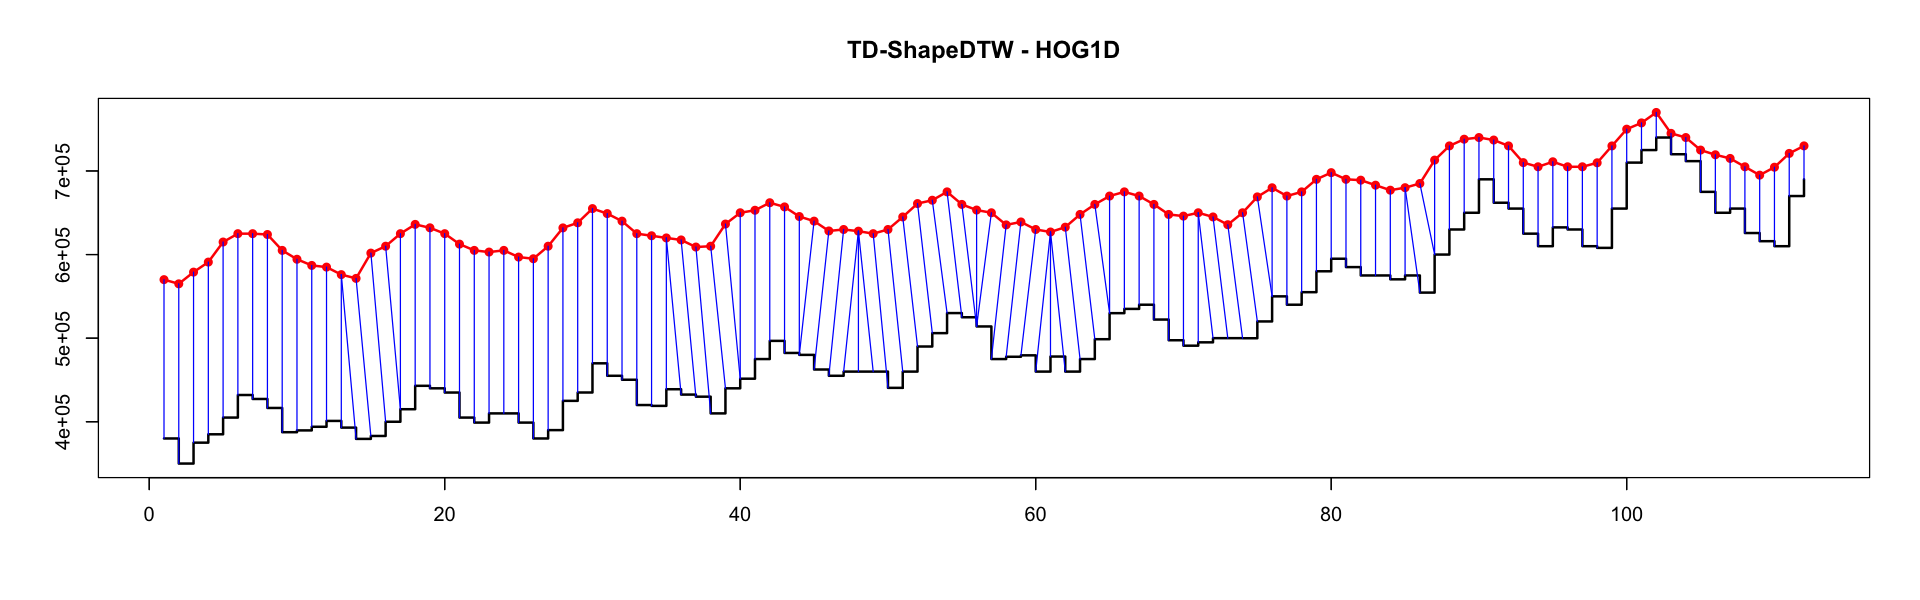

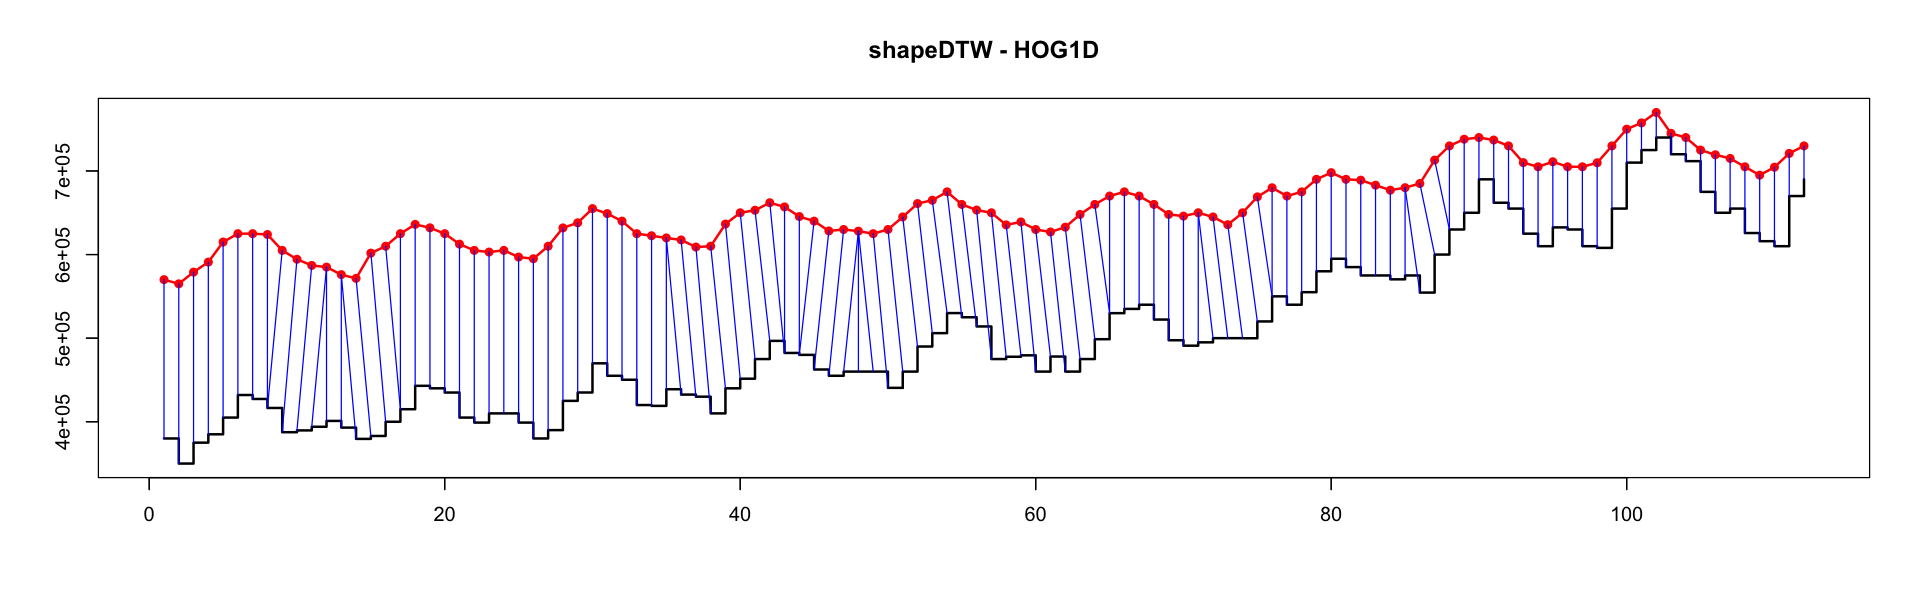

In [14]:
# Top 1 matching from TD-shapeDTW
metro_control <- metro_t_dist[order(td_shapedtw_rank)]$region[2]

# TD-shapeDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    metro_t_dist_results[[metro_control]]$align_td_shapeDTW$match)
title("TD-ShapeDTW - HOG1D")

# shapeDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    metro_t_dist_results[[metro_control]]$align_shapeDTW$match)
title("shapeDTW - HOG1D")

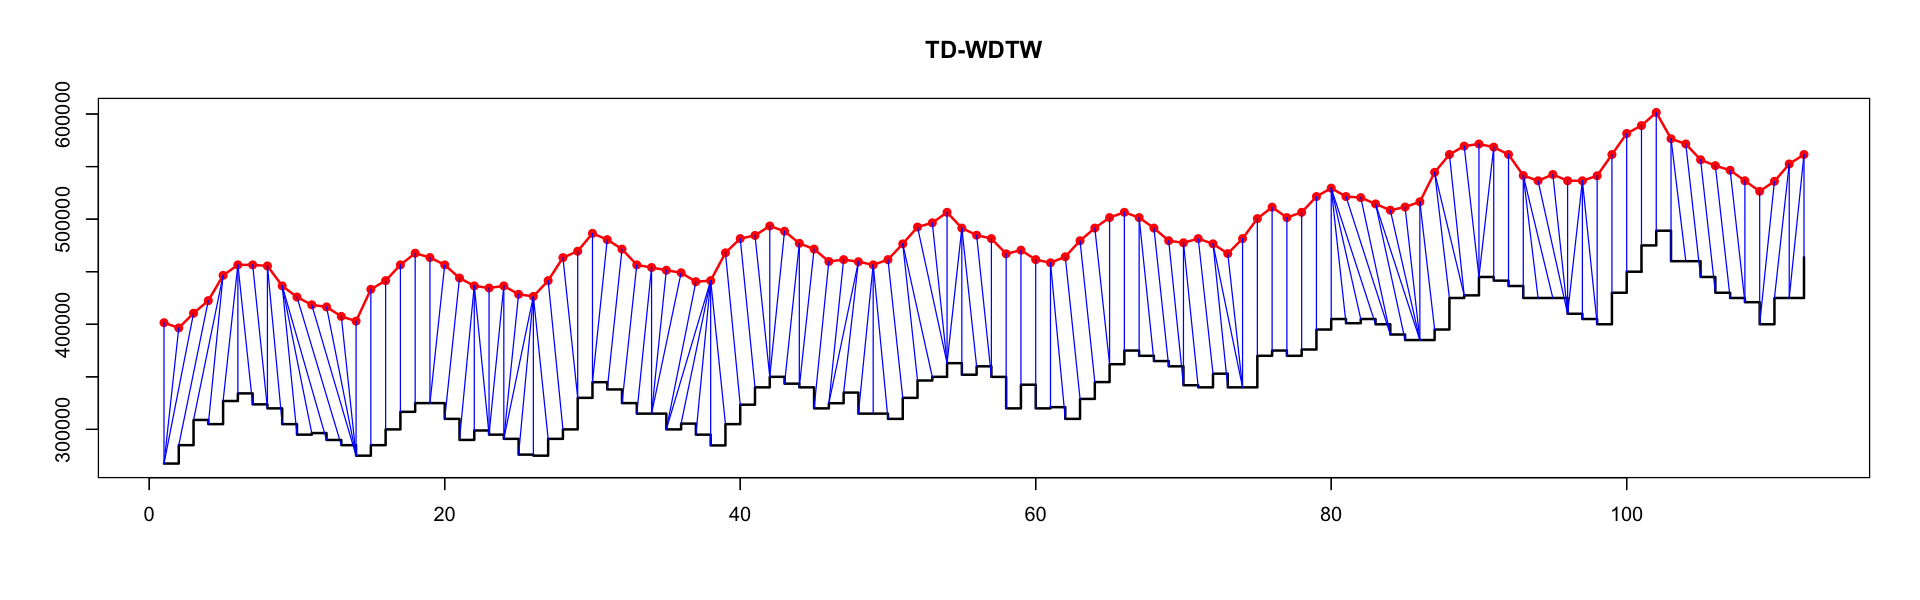

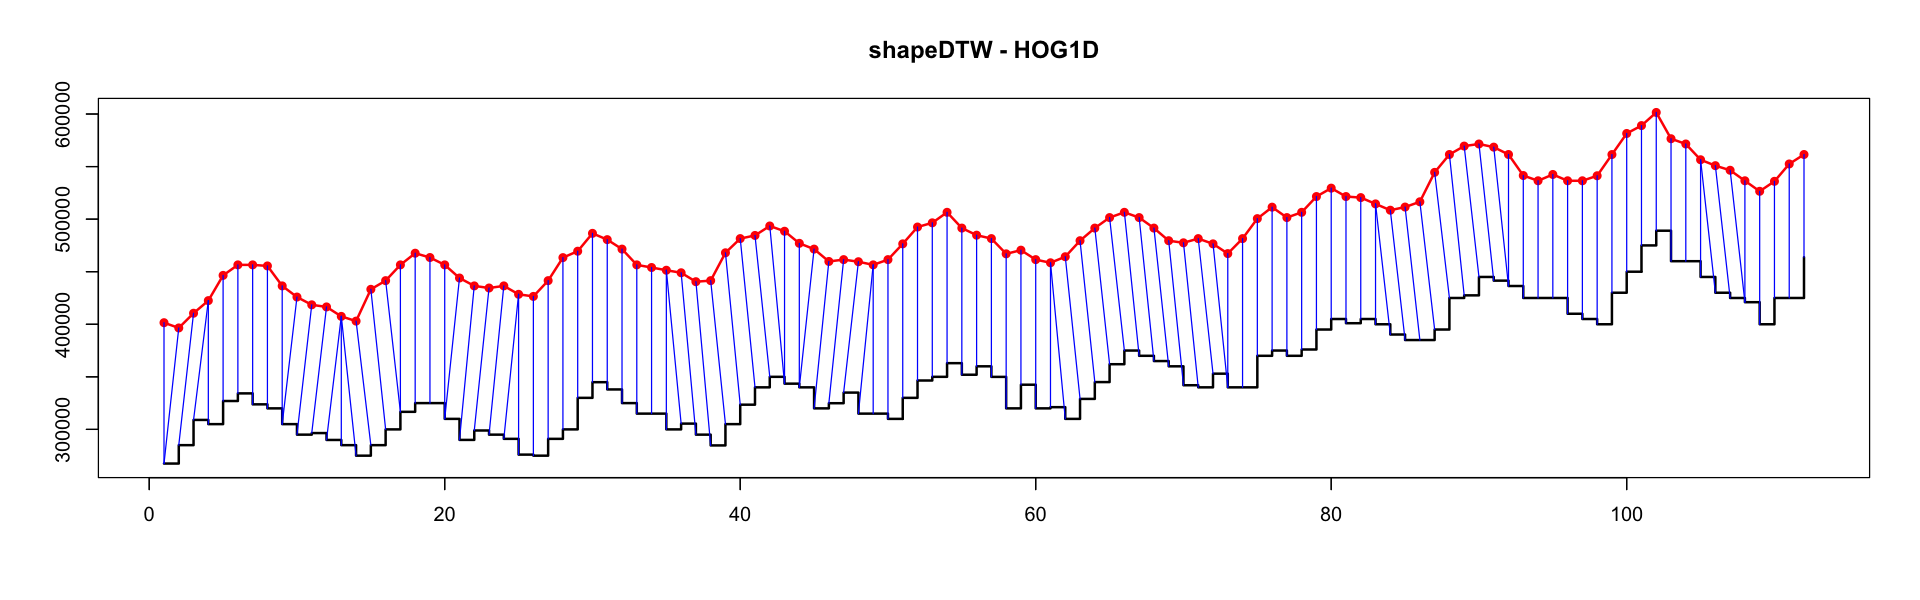

In [15]:
# Significant difference in matching between shapeDTW and TD-WDTW
metro_control <- metro_t_dist[order(td_shapedtw_rank)]$region[6]

# TD-WDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    cbind(metro_t_dist_results[[metro_control]]$align_td_WDTW$p, metro_t_dist_results[[metro_control]]$align_td_WDTW$q))
title("TD-WDTW")

# shapeDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    metro_t_dist_results[[metro_control]]$align_shapeDTW$match)
title("shapeDTW - HOG1D")

#### 4.2 Data Plot

In [16]:
plotMatchingSequences <- function(metro_set){
  ggplot(data = dt_sel[region %in% metro_set], aes(x = period_begin, y = median_sale_price, color = region)) + 
    geom_line(aes(linetype = region)) +
    geom_point() +
    scale_x_date(breaks = "3 month") + 
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
      axis.title = element_text(size = 16), axis.text = element_text(size = 16), 
      legend.title = element_text(size = 16), legend.text = element_text(size = 16),
      plot.background = element_blank(),
      panel.grid.major = element_blank()
    )
}

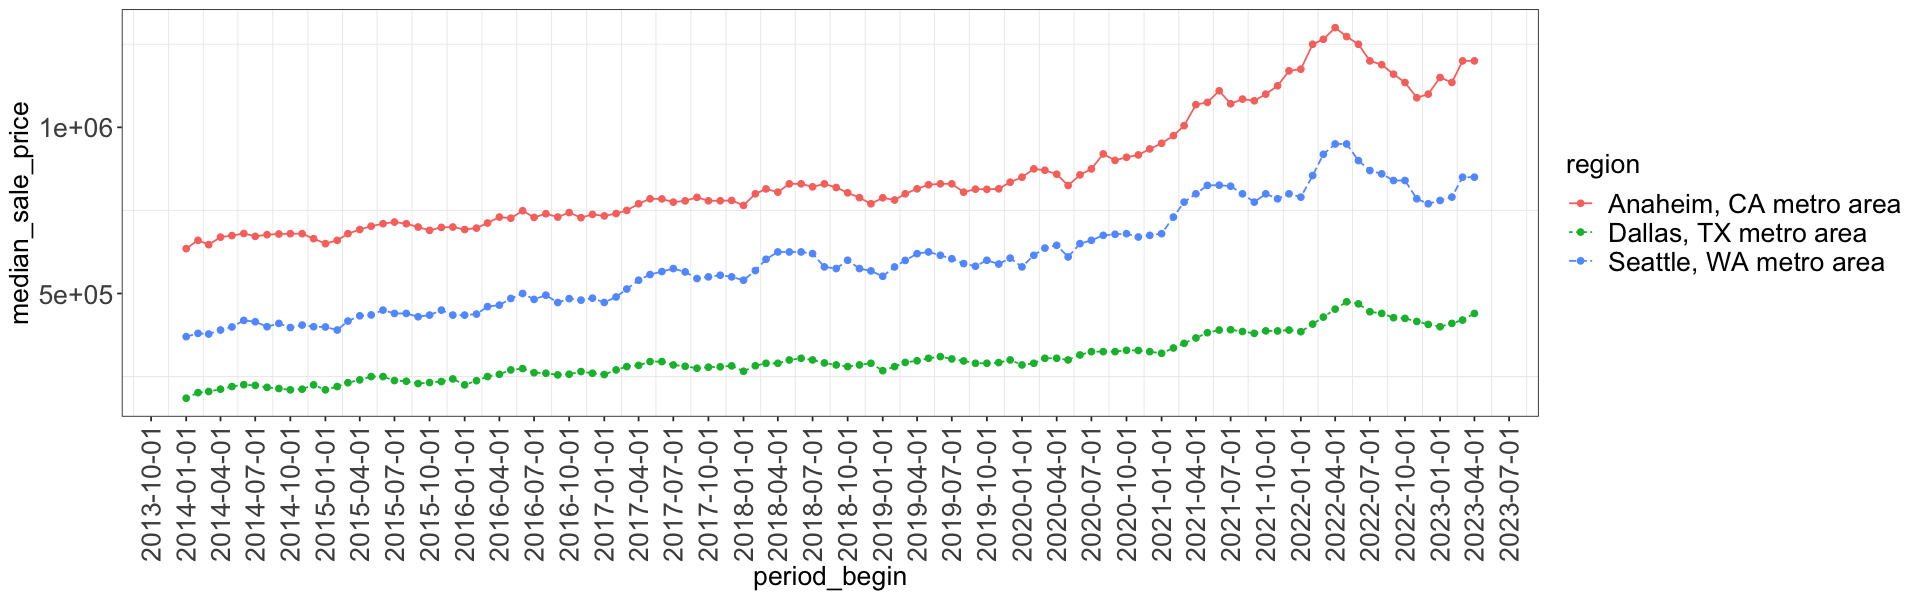

In [17]:
# Seattle
metro_t <- "Seattle, WA metro area"
metro_sel <- c(metro_t, "Dallas, TX metro area", "Anaheim, CA metro area")
plotMatchingSequences(metro_sel)


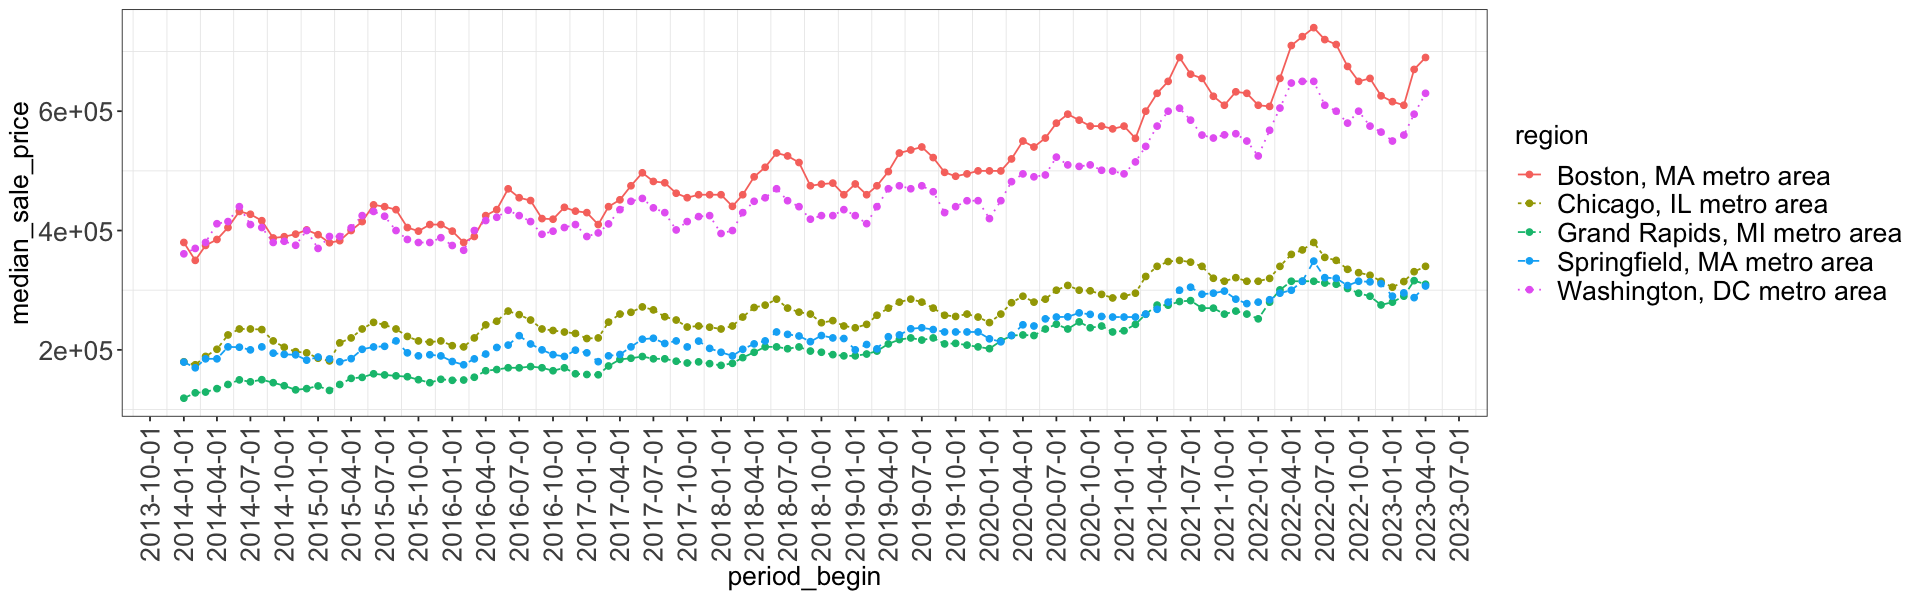

In [18]:
# Chicago
metro_t <- "Chicago, IL metro area"
metro_sel <- c(metro_t, "Boston, MA metro area", "Washington, DC metro area",  # td_shapedtw-rank2, 4
               "Grand Rapids, MI metro area", "Springfield, MA metro area") # td_shapedtw-rank6, 17, # td_wdtw-rank16
plotMatchingSequences(metro_sel)

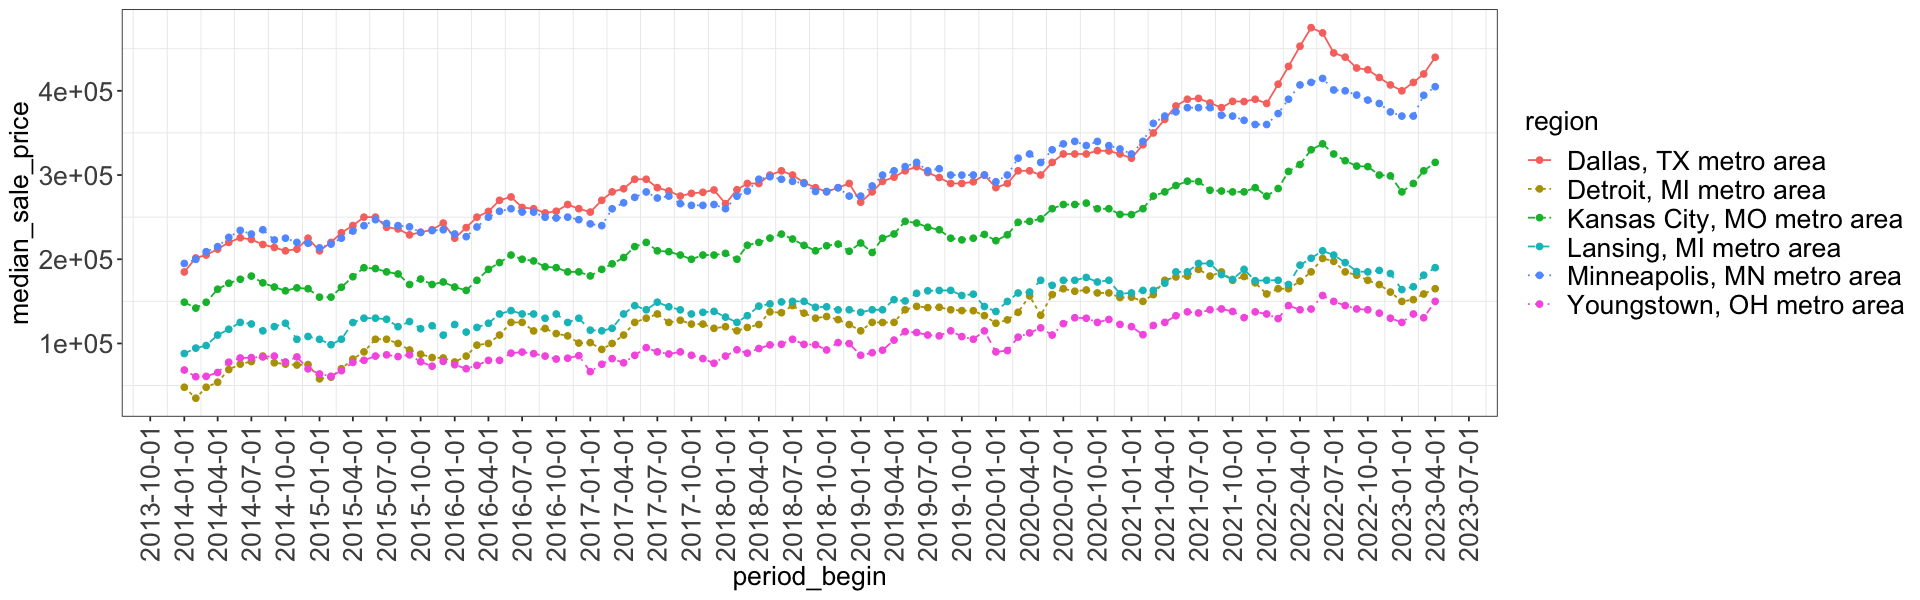

In [19]:
# Detroit
metro_t <- "Detroit, MI metro area"
metro_sel <- c(metro_t, "Kansas City, MO metro area", "Minneapolis, MN metro area", "Dallas, TX metro area", # td_shapedtw-rank4, 6, 16
               "Youngstown, OH metro area", "Lansing, MI metro area")  # td_wdtw-rank11, 19
plotMatchingSequences(metro_sel)

### 5. Causal Impact

In [20]:
# Causal impact model
CausalImpactModel <- function(metro_name, test_date, alpha = 0.05, num_query = 10){
  
  # Get the distances and ranking of control metros
  output <- calMetroDist(metro_name = metro_name)
  metro_t_dist <- as.data.frame(output$metro_t_dist)
  metro_t_dist_results <- output$metro_t_dist_results

  causal_effect_results_list <- plot_results_list <- mape_results_list <-list()
  for (i in 1:length(metrics_rank)){
    
    # Get top 10 control and the treatment metro
    metro_t <- metro_name
    metro_sel <- metro_t_dist[metro_t_dist[, metrics_rank[i]]<=(num_query+1), 'region']
    metro_c <- metro_sel[metro_sel!=metro_t]

    # Get the target variable: median sale price
    dt_metro_t <- dt_sel[(region == metro_t) & (period_begin <= end_date), 
                             c("period_begin", "median_sale_price")]
    dt_metro_c_all <- dt_sel[(region %in% metro_c) & (period_begin <= end_date), 
                                 c("region", "period_begin", "median_sale_price")]
    dt_metro_c <- dcast(dt_metro_c_all, period_begin ~ region, value.var = "median_sale_price")
    
    # Final data used in CausalImpact
    dt_final <- as.data.frame(merge(dt_metro_t[, c("period_begin", "median_sale_price")], 
                                    dt_metro_c, 
                                    by = "period_begin"))
    dt_final <- zoo(dt_final[,2:3], month_list)
    
    # Set the observed data in the post_treatment period to NAs
    post_obs <- as.numeric(dt_final$median_sale_price[month_list >= test_date])
    dt_final$median_sale_price[month_list >= test_date] <- NA
    
    # Use BSTS package to specify custom model by adding seasonality and local linear trend
    ss <- list()
    ss <- AddSeasonal(ss, y = dt_final$median_sale_price, nseasons = 12) # Add seasonality
    ss <- AddLocalLinearTrend(ss, y = dt_final$median_sale_price) # Add linear trend (upward)
    bsts_model <- bsts(median_sale_price ~., state.specification = ss, data = as.data.frame(dt_final), niter = 2000, ping = 0)
    causal_impact_model <- CausalImpact(bsts.model = bsts_model, post.period.response = post_obs, alpha = alpha)
    
    # Get post-period predictions and compute MAPE
    post_pred <- causal_impact_model$series$point.pred[(n+1-length(post_obs)):n]
    mape <- round(mean(abs(post_obs - post_pred)/post_obs) * 100, 2)
    
    # Plot the results
    options(repr.plot.width = 16, repr.plot.height = 9)
    plot_results <- plot(causal_impact_model) +
      scale_x_continuous(breaks = seq(1, length(month_list), by = 3),
                         labels = month_list[seq(1, length(month_list), by = 3)],
                         guide = guide_axis(angle = 90)) + 
      labs(title = paste0(metro_t, ": ", metrics[i]))
    #print(plot_results)
    
    # Print the results
    #cat(paste("# -----", metrics[i], "-----\n"))
    #summary(causal_impact_model)

    # Save the output
    causal_effect_results_list[[i]] <- causal_impact_model
    mape_results_list[[i]] <- mape
    plot_results_list[[i]] <- plot_results
  }
  
  return(list("metro_t_dist" = metro_t_dist,
              "metro_t_dist_results" = metro_t_dist_results,
              "causal_impact_model" = causal_effect_results_list,
              "model_mape_results" = mape_results_list,
              "plot_causal_impact_results" = plot_results_list))
}

In [22]:
set.seed(20230625)
m <- 100
random_metro <- sample(unique(dt_sel$region), m, replace = FALSE)
test_date <- as.Date("2023-01-01") # Specify test date

output_list <- list()
for (k in 1:m){
  output_list[[k]] <- CausalImpactModel(metro_name = random_metro[k], test_date = test_date)
  print(paste("# -----", random_metro[k], "-----\n"))
}

Time difference of 40.17 secs
[1] "# ----- Flint, MI metro area -----\n"
Time difference of 38.29 secs
[1] "# ----- Fort Lauderdale, FL metro area -----\n"
Time difference of 36.31 secs
[1] "# ----- Huntsville, TX metro area -----\n"
Time difference of 36.08 secs
[1] "# ----- Sherman, TX metro area -----\n"
Time difference of 40.87 secs
[1] "# ----- Iron Mountain, MI metro area -----\n"
Time difference of 35.73 secs
[1] "# ----- San Rafael, CA metro area -----\n"
Time difference of 35.9 secs
[1] "# ----- Des Moines, IA metro area -----\n"
Time difference of 37.95 secs
[1] "# ----- Lewisburg, TN metro area -----\n"
Time difference of 35.32 secs
[1] "# ----- South Bend, IN metro area -----\n"
Time difference of 35.81 secs
[1] "# ----- Jefferson, GA metro area -----\n"
Time difference of 35.79 secs
[1] "# ----- Fernley, NV metro area -----\n"
Time difference of 37.82 secs
[1] "# ----- New Bern, NC metro area -----\n"
Time difference of 37.39 secs
[1] "# ----- Johnson City, TN metro area -

In [23]:
mapeCalc <- function(output, metro_name){
  mape <- as.data.frame(cbind(
    rep(metro_name, 5),
    metrics, 
    output$model_mape_results
  ))
  colnames(mape) <- c("region", "matching_algorithm", "mape")
  return(mape)
}

In [24]:
output_df <- mapeCalc(output = output_list[[1]], metro_name = random_metro[1])
for (k in 2:m){
  output_df <- rbind(output_df, mapeCalc(output_list[[k]], random_metro[k]))
}
fwrite(output_df, file = "demo_HousingMarket/housing_output_100.csv", row.names = FALSE)

#### 5.1 San Jose

Time difference of 41 secs
# ----- dtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1421298 (109094)     5685191 (436376)  
95% CI                   [1200812, 1634173]   [4803249, 6536693]
                                                                
Absolute effect (s.d.)   131702 (109094)      526809 (436376)   
95% CI                   [-81173, 352188]     [-324693, 1408751]
                                                                
Relative effect (s.d.)   9.3% (7.7%)          9.3% (7.7%)       
95% CI                   [-5.7%, 25%]         [-5.7%, 25%]      

Posterior tail-area probability p:   0.10822
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



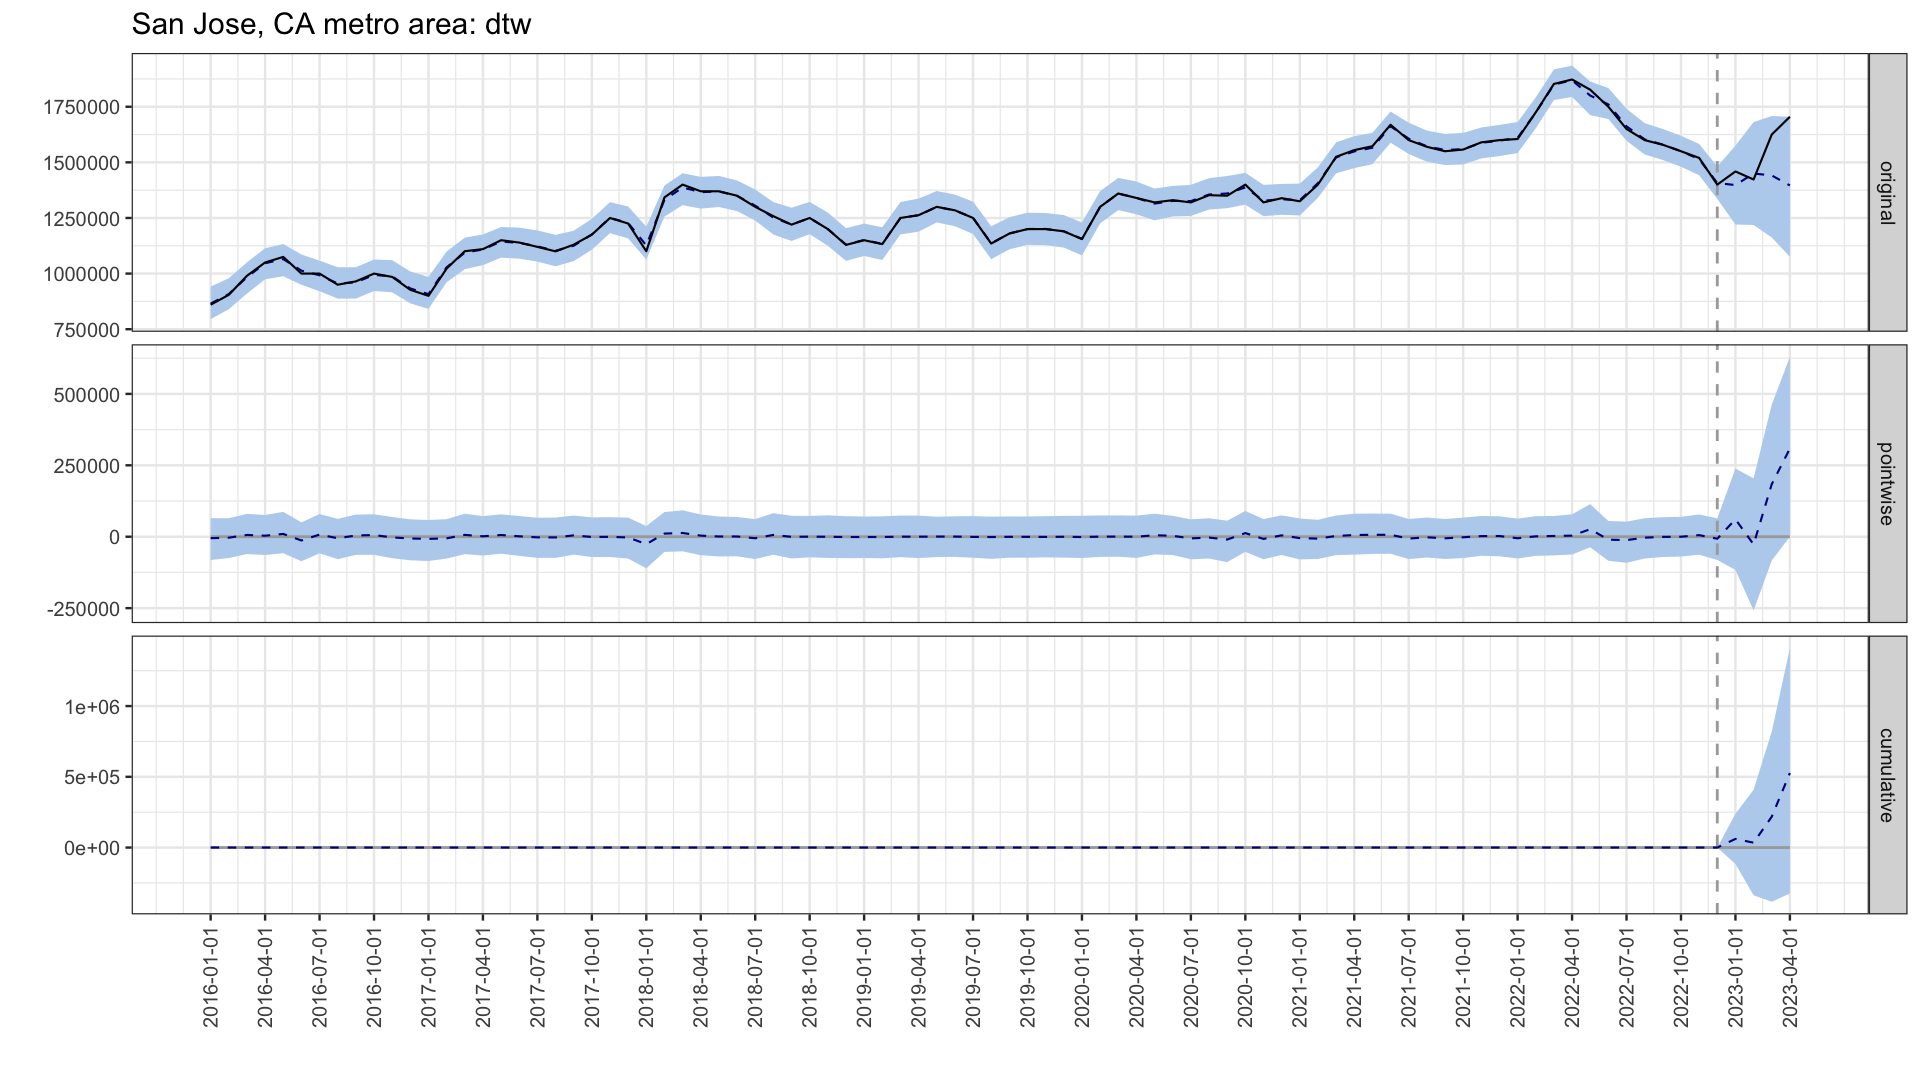

# ----- wdtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1429547 (104494)     5718188 (417977)  
95% CI                   [1214213, 1629747]   [4856851, 6518988]
                                                                
Absolute effect (s.d.)   123453 (104494)      493812 (417977)   
95% CI                   [-76747, 338787]     [-306988, 1355149]
                                                                
Relative effect (s.d.)   8.6% (7.3%)          8.6% (7.3%)       
95% CI                   [-5.4%, 24%]         [-5.4%, 24%]      

Posterior tail-area probability p:   0.10925
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



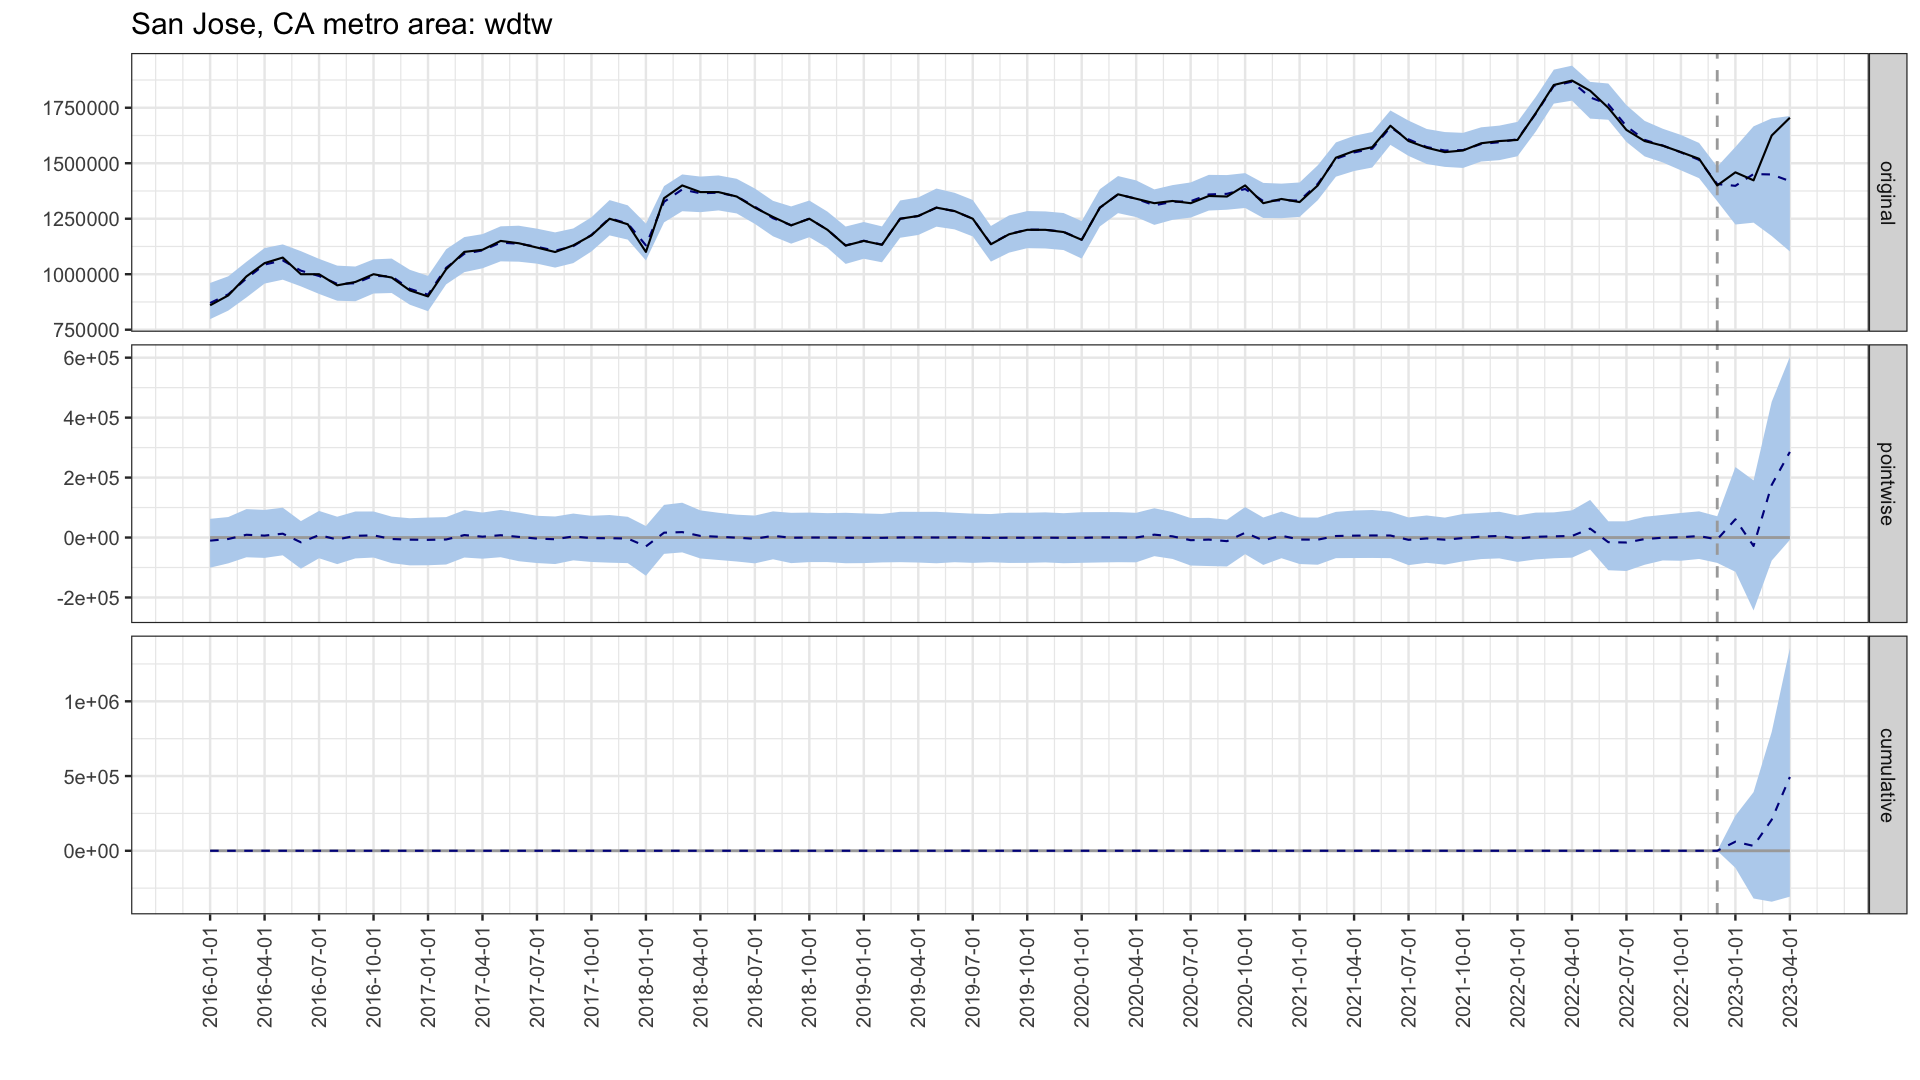

# ----- td_wdtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1413965 (112850)     5655861 (451400)  
95% CI                   [1191094, 1634361]   [4764375, 6537443]
                                                                
Absolute effect (s.d.)   139035 (112850)      556139 (451400)   
95% CI                   [-81361, 361906]     [-325443, 1447625]
                                                                
Relative effect (s.d.)   9.8% (8%)            9.8% (8%)         
95% CI                   [-5.8%, 26%]         [-5.8%, 26%]      

Posterior tail-area probability p:   0.10589
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



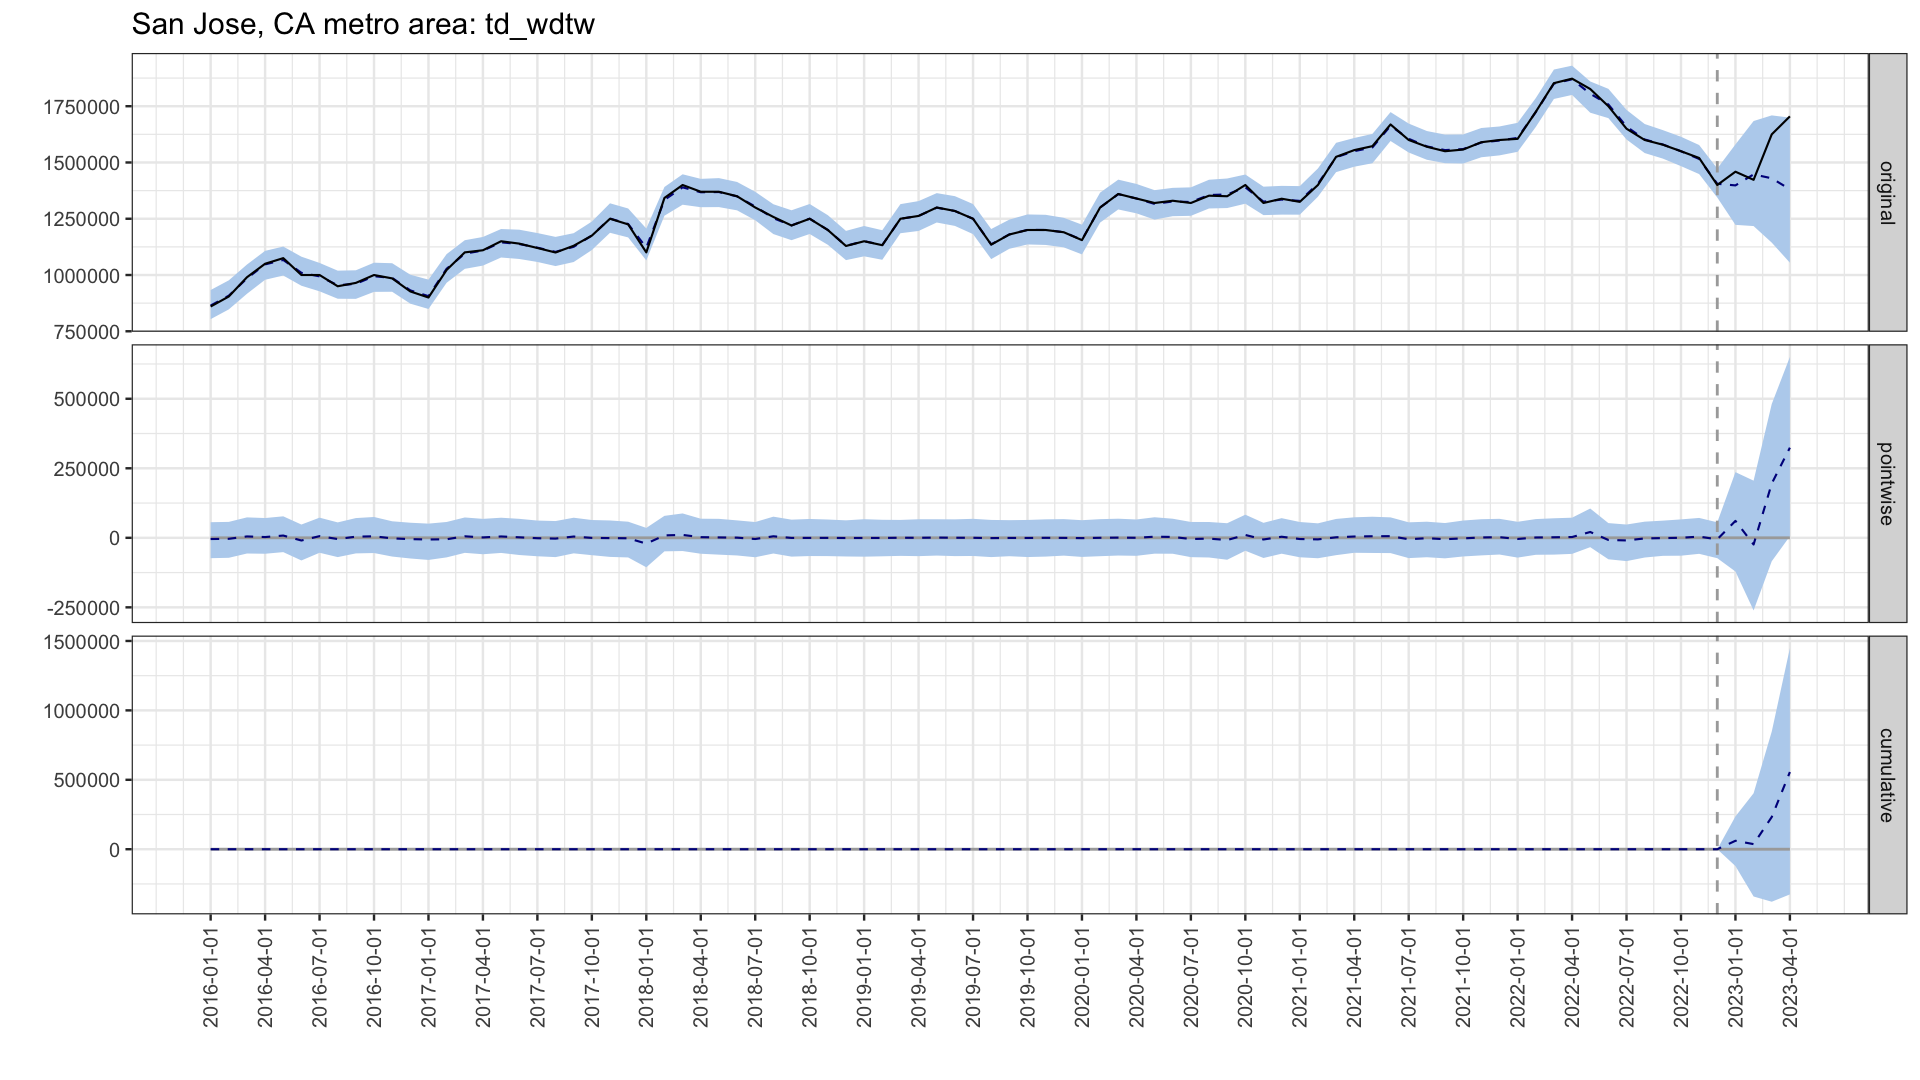

# ----- shapedtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1447031 (90515)      5788124 (362062)  
95% CI                   [1272845, 1622057]   [5091382, 6488230]
                                                                
Absolute effect (s.d.)   105969 (90515)       423876 (362062)   
95% CI                   [-69057, 280155]     [-276230, 1120618]
                                                                
Relative effect (s.d.)   7.3% (6.3%)          7.3% (6.3%)       
95% CI                   [-4.8%, 19%]         [-4.8%, 19%]      

Posterior tail-area probability p:   0.12293
Posterior prob. of a causal effect:  88%

For more details, type: summary(impact, "report")



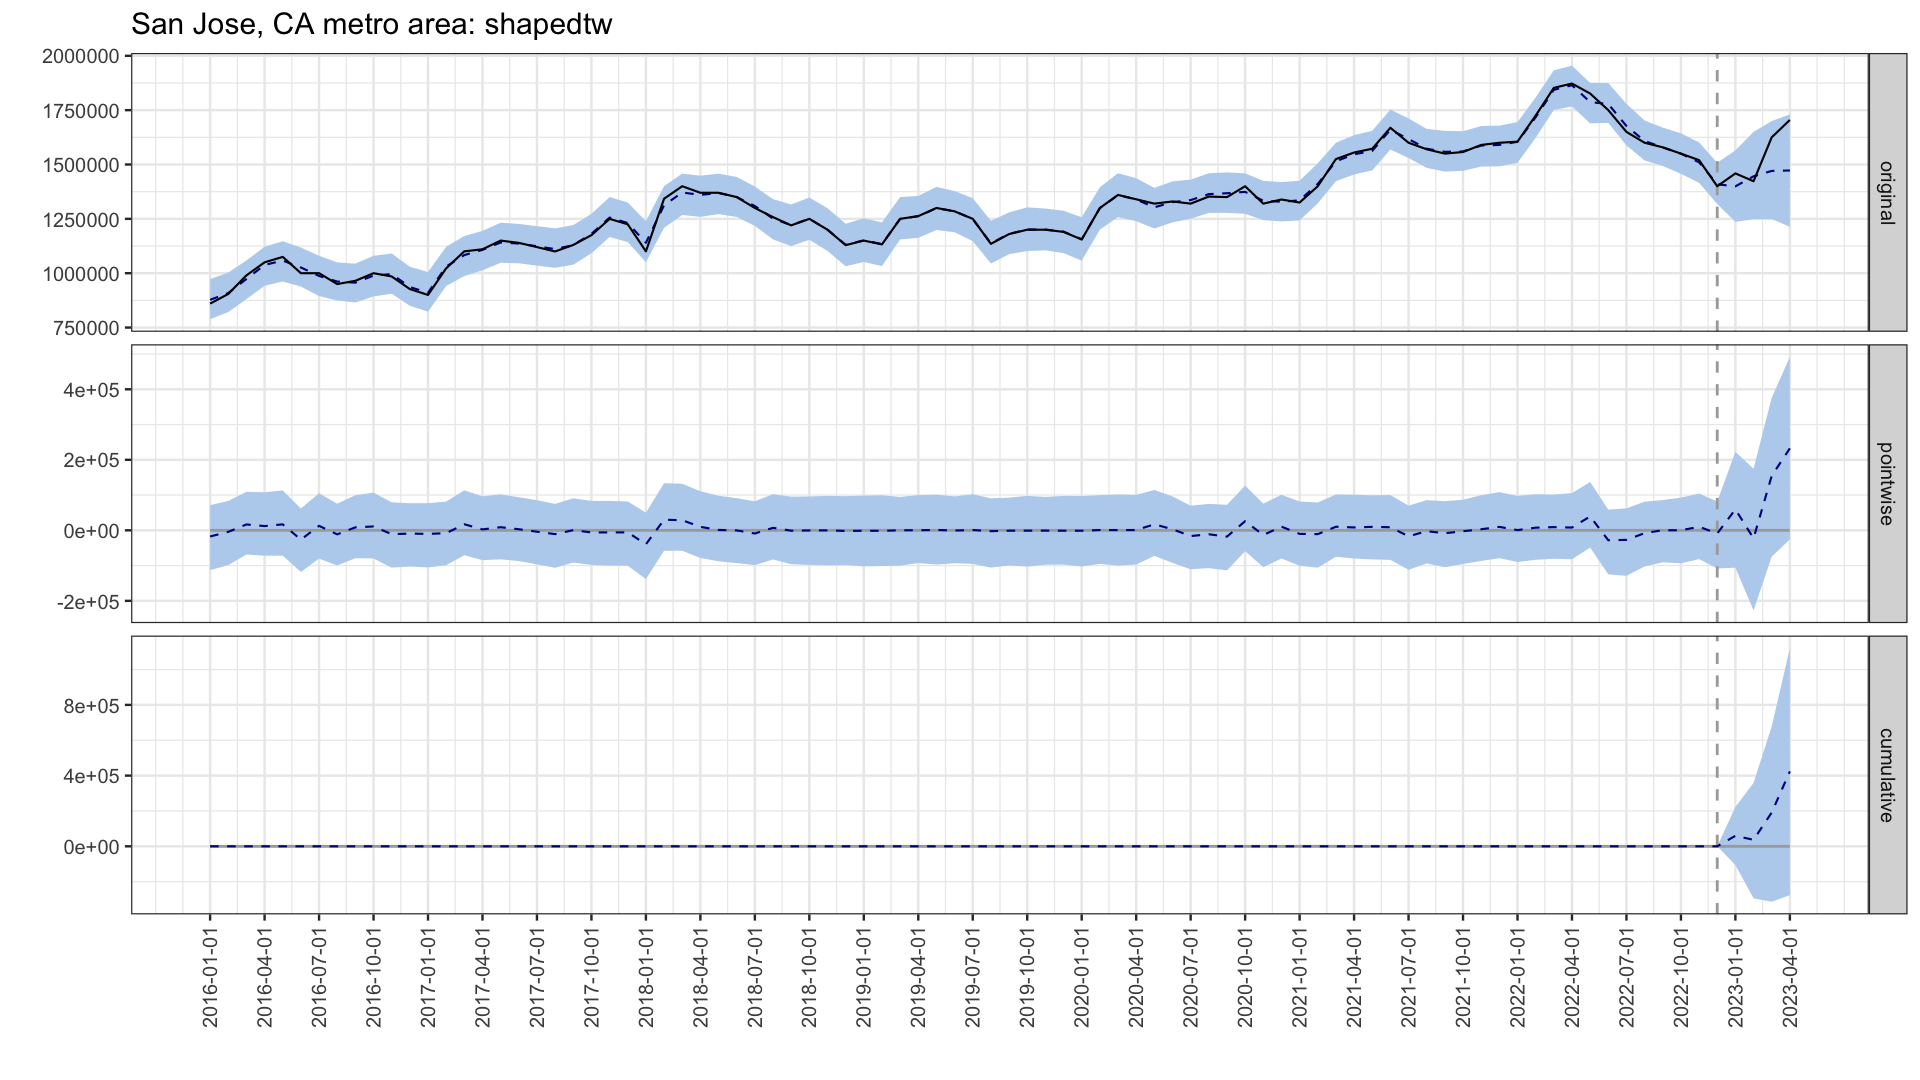

# ----- td_shapedtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1461341 (88646)      5845364 (354586)  
95% CI                   [1285993, 1642509]   [5143972, 6570035]
                                                                
Absolute effect (s.d.)   91659 (88646)        366636 (354586)   
95% CI                   [-89509, 267007]     [-358035, 1068028]
                                                                
Relative effect (s.d.)   6.3% (6.1%)          6.3% (6.1%)       
95% CI                   [-6.1%, 18%]         [-6.1%, 18%]      

Posterior tail-area probability p:   0.16409
Posterior prob. of a causal effect:  84%

For more details, type: summary(impact, "report")



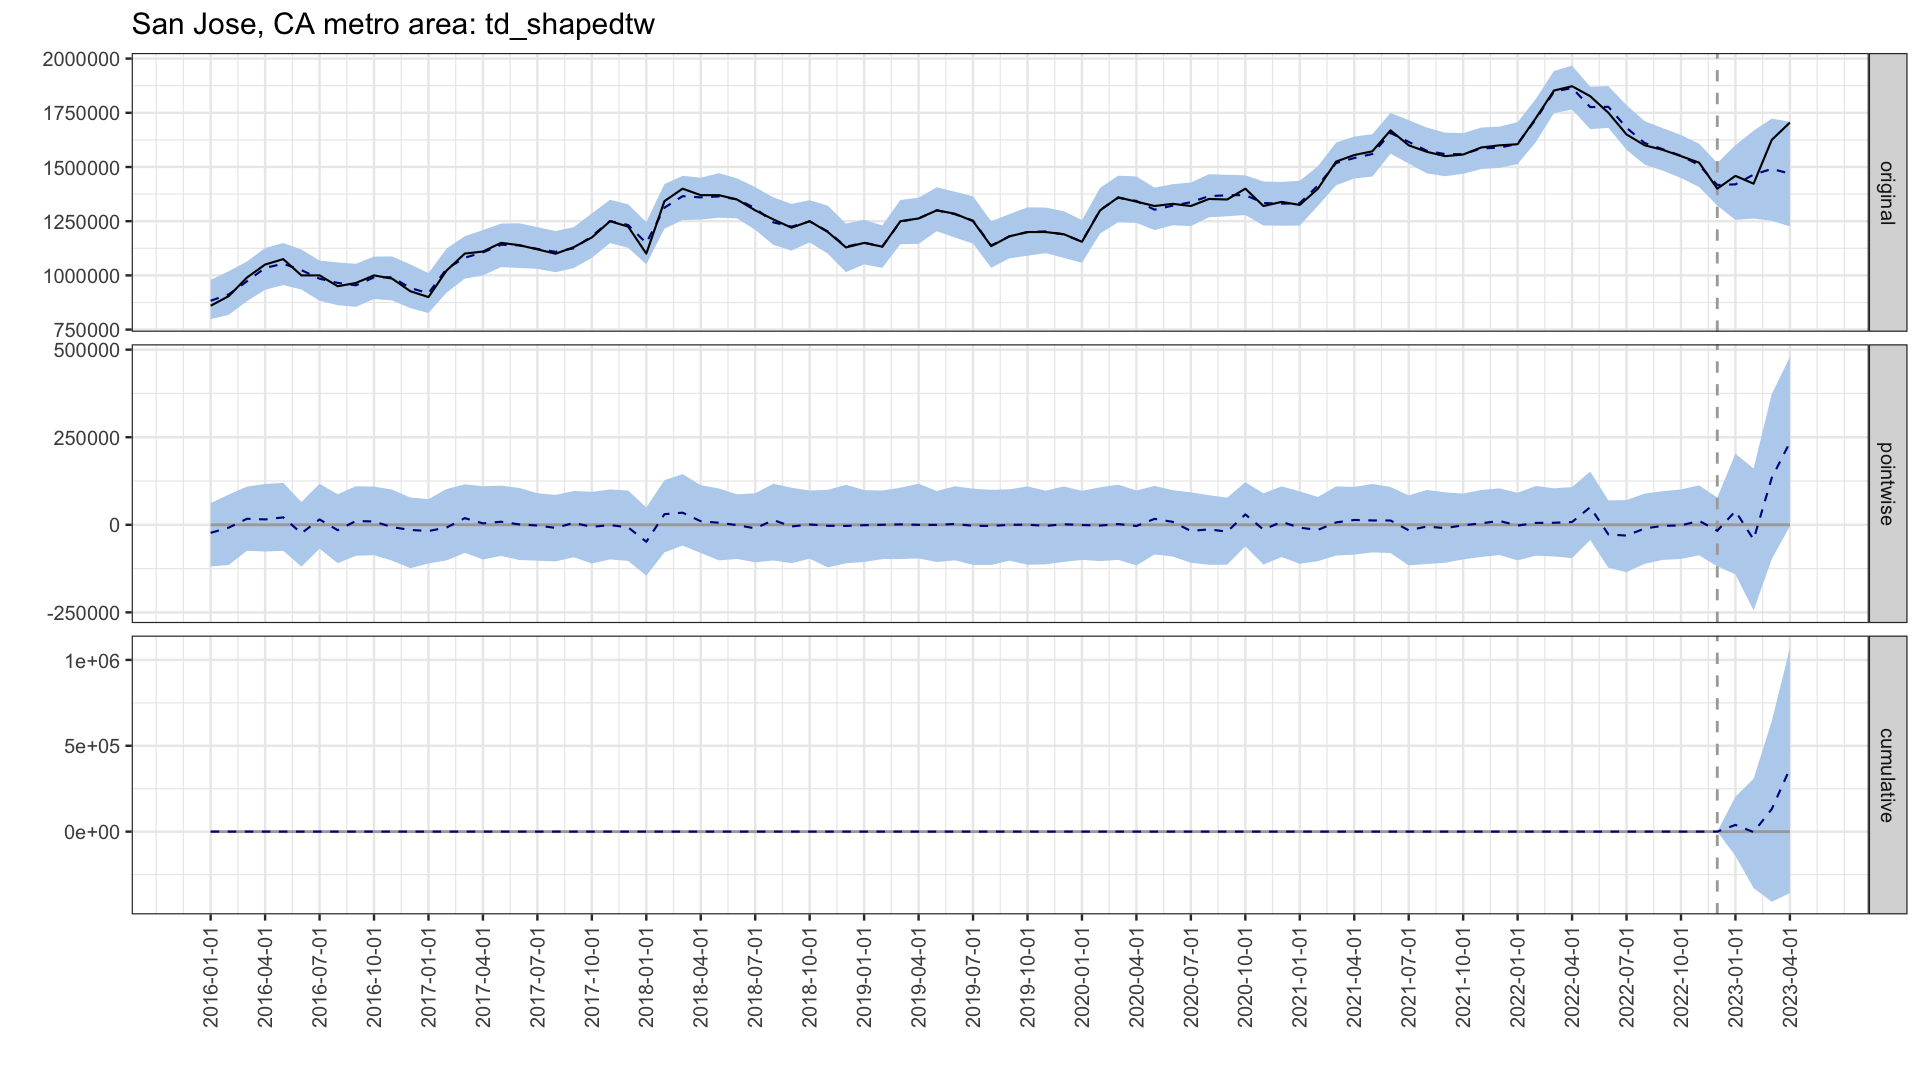

In [21]:
causal_SanJose <- CausalImpactModel(metro_name = "San Jose, CA metro area")

#### 5.2 Austin, TX

Time difference of 57.29 secs
# ----- dtw -----
Posterior inference {CausalImpact}

                         Average           Cumulative       
Actual                   454000            1816000          
Prediction (s.d.)        450519 (25394)    1802076 (101574) 
95% CI                   [399999, 5e+05]   [1599994, 2e+06] 
                                                            
Absolute effect (s.d.)   3481 (25394)      13924 (101574)   
95% CI                   [-45581, 54001]   [-182322, 216006]
                                                            
Relative effect (s.d.)   0.77% (5.6%)      0.77% (5.6%)     
95% CI                   [-10%, 12%]       [-10%, 12%]      

Posterior tail-area probability p:   0.4295
Posterior prob. of a causal effect:  57%

For more details, type: summary(impact, "report")



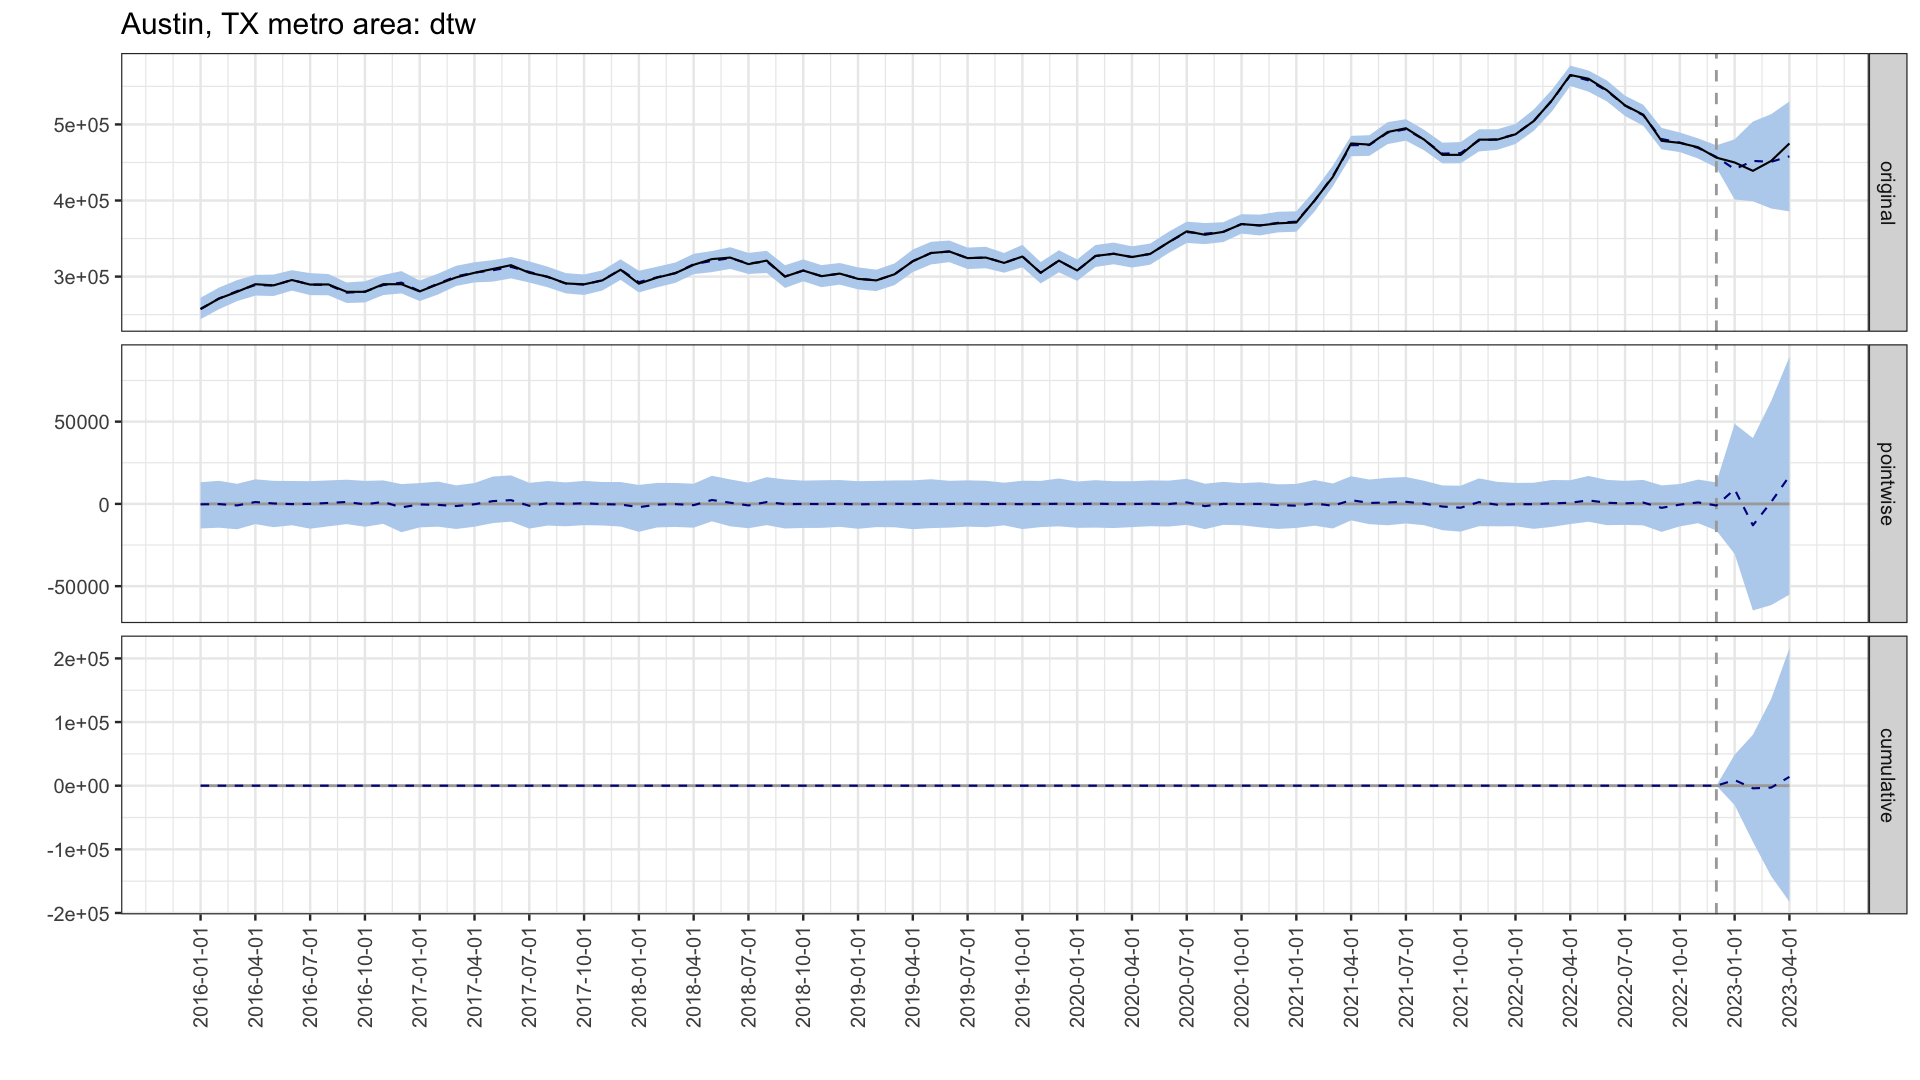

# ----- wdtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        433035 (33515)     1732139 (134061)  
95% CI                   [361669, 491949]   [1446674, 1967795]
                                                              
Absolute effect (s.d.)   20965 (33515)      83861 (134061)    
95% CI                   [-37949, 92331]    [-151795, 369326] 
                                                              
Relative effect (s.d.)   4.8% (7.7%)        4.8% (7.7%)       
95% CI                   [-8.8%, 21%]       [-8.8%, 21%]      

Posterior tail-area probability p:   0.28086
Posterior prob. of a causal effect:  72%

For more details, type: summary(impact, "report")



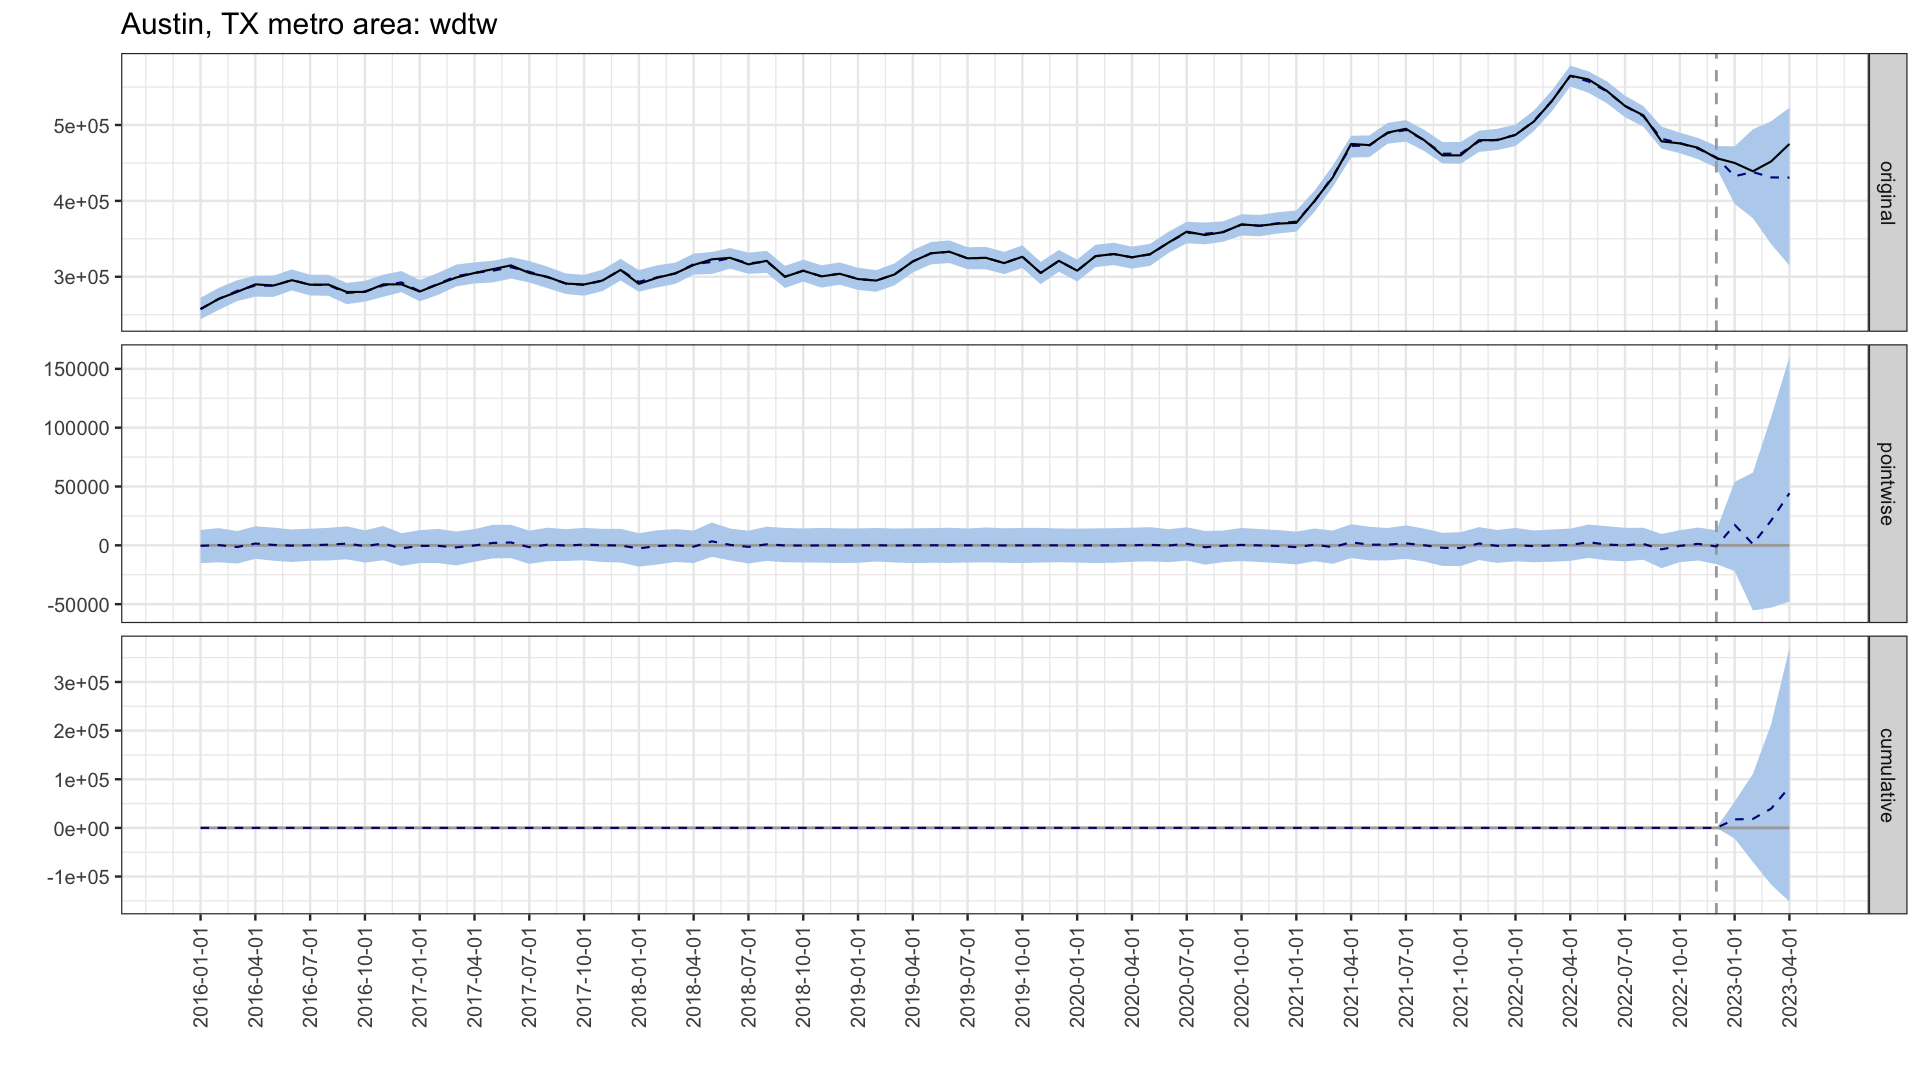

# ----- td_wdtw -----
Posterior inference {CausalImpact}

                         Average           Cumulative       
Actual                   454000            1816000          
Prediction (s.d.)        430579 (35388)    1722318 (141551) 
95% CI                   [355727, 5e+05]   [1422907, 2e+06] 
                                                            
Absolute effect (s.d.)   23421 (35388)     93682 (141551)   
95% CI                   [-41174, 98273]   [-164694, 393093]
                                                            
Relative effect (s.d.)   5.4% (8.2%)       5.4% (8.2%)      
95% CI                   [-9.6%, 23%]      [-9.6%, 23%]     

Posterior tail-area probability p:   0.25662
Posterior prob. of a causal effect:  74%

For more details, type: summary(impact, "report")



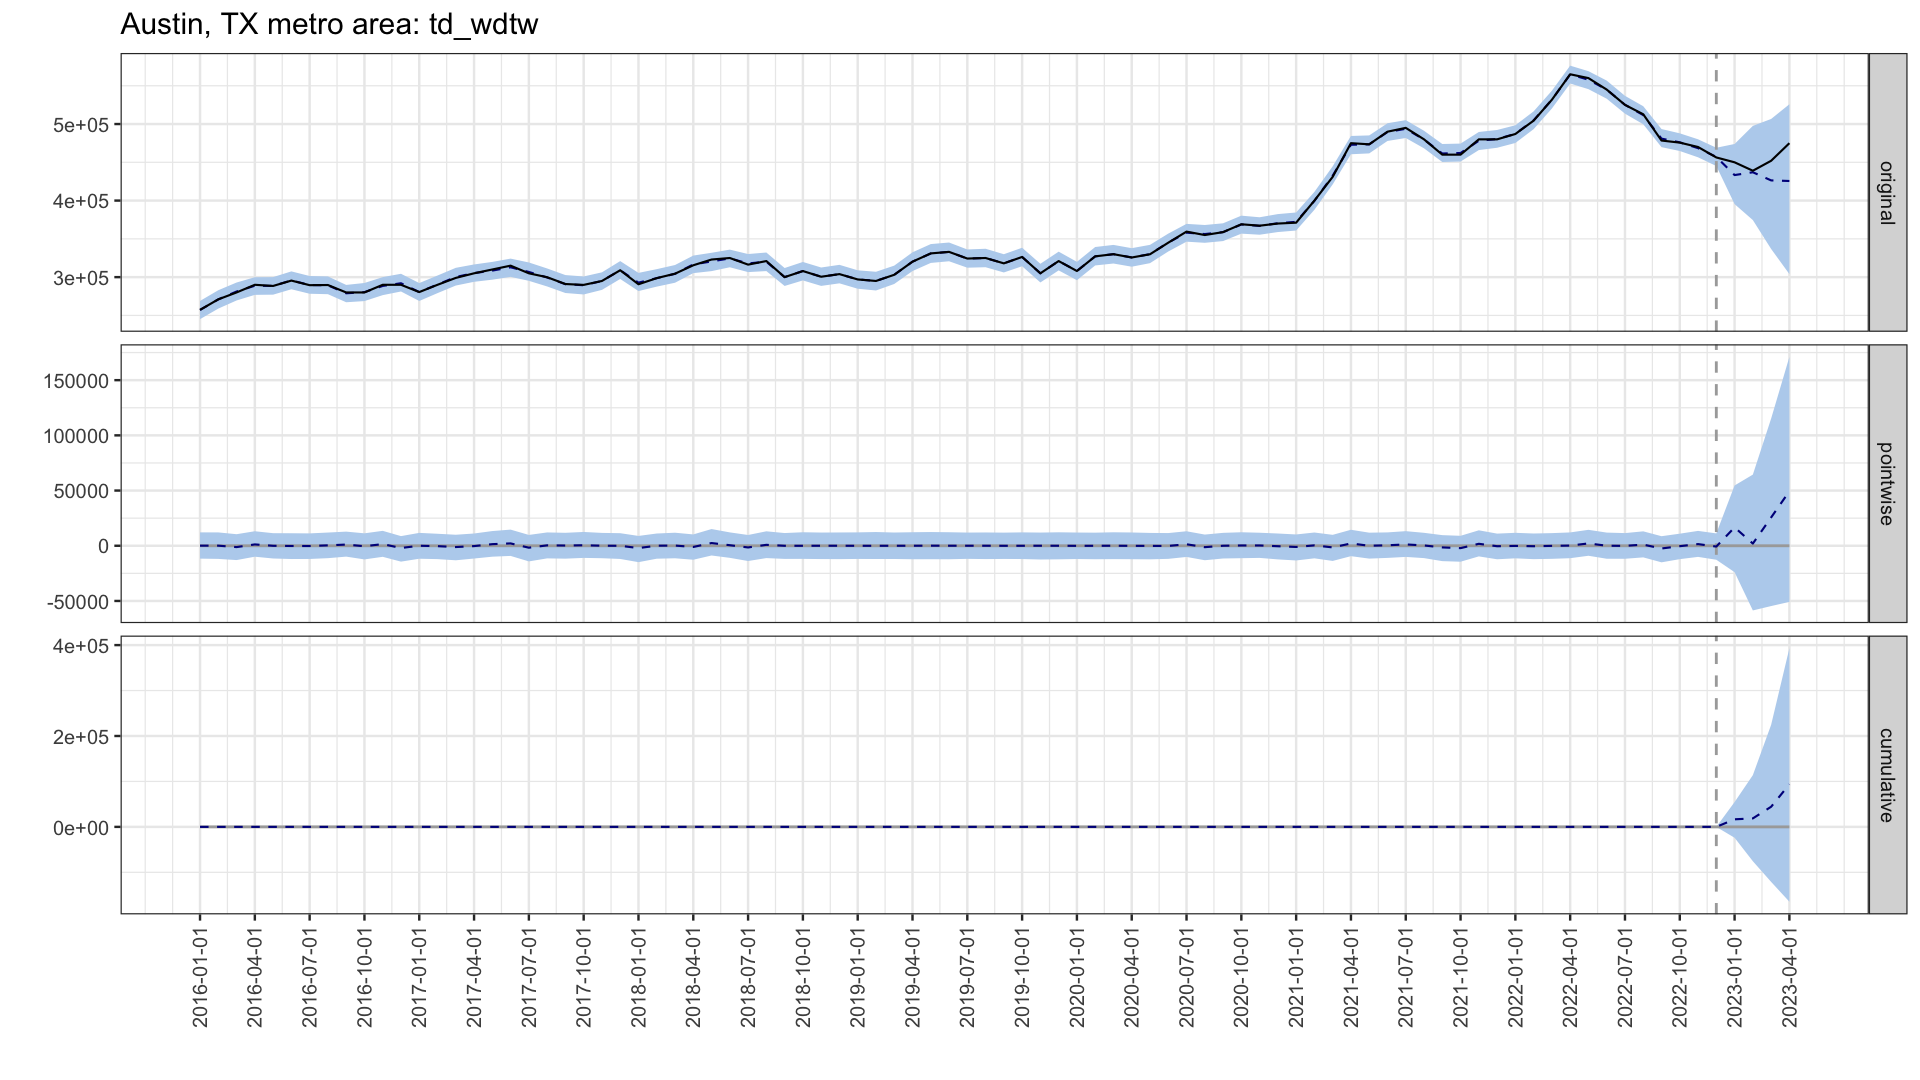

# ----- shapedtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        417513 (36738)     1670050 (146951)  
95% CI                   [344872, 489307]   [1379486, 1957226]
                                                              
Absolute effect (s.d.)   36487 (36738)      145950 (146951)   
95% CI                   [-35307, 109128]   [-141226, 436514] 
                                                              
Relative effect (s.d.)   8.7% (8.8%)        8.7% (8.8%)       
95% CI                   [-8.5%, 26%]       [-8.5%, 26%]      

Posterior tail-area probability p:   0.15682
Posterior prob. of a causal effect:  84%

For more details, type: summary(impact, "report")



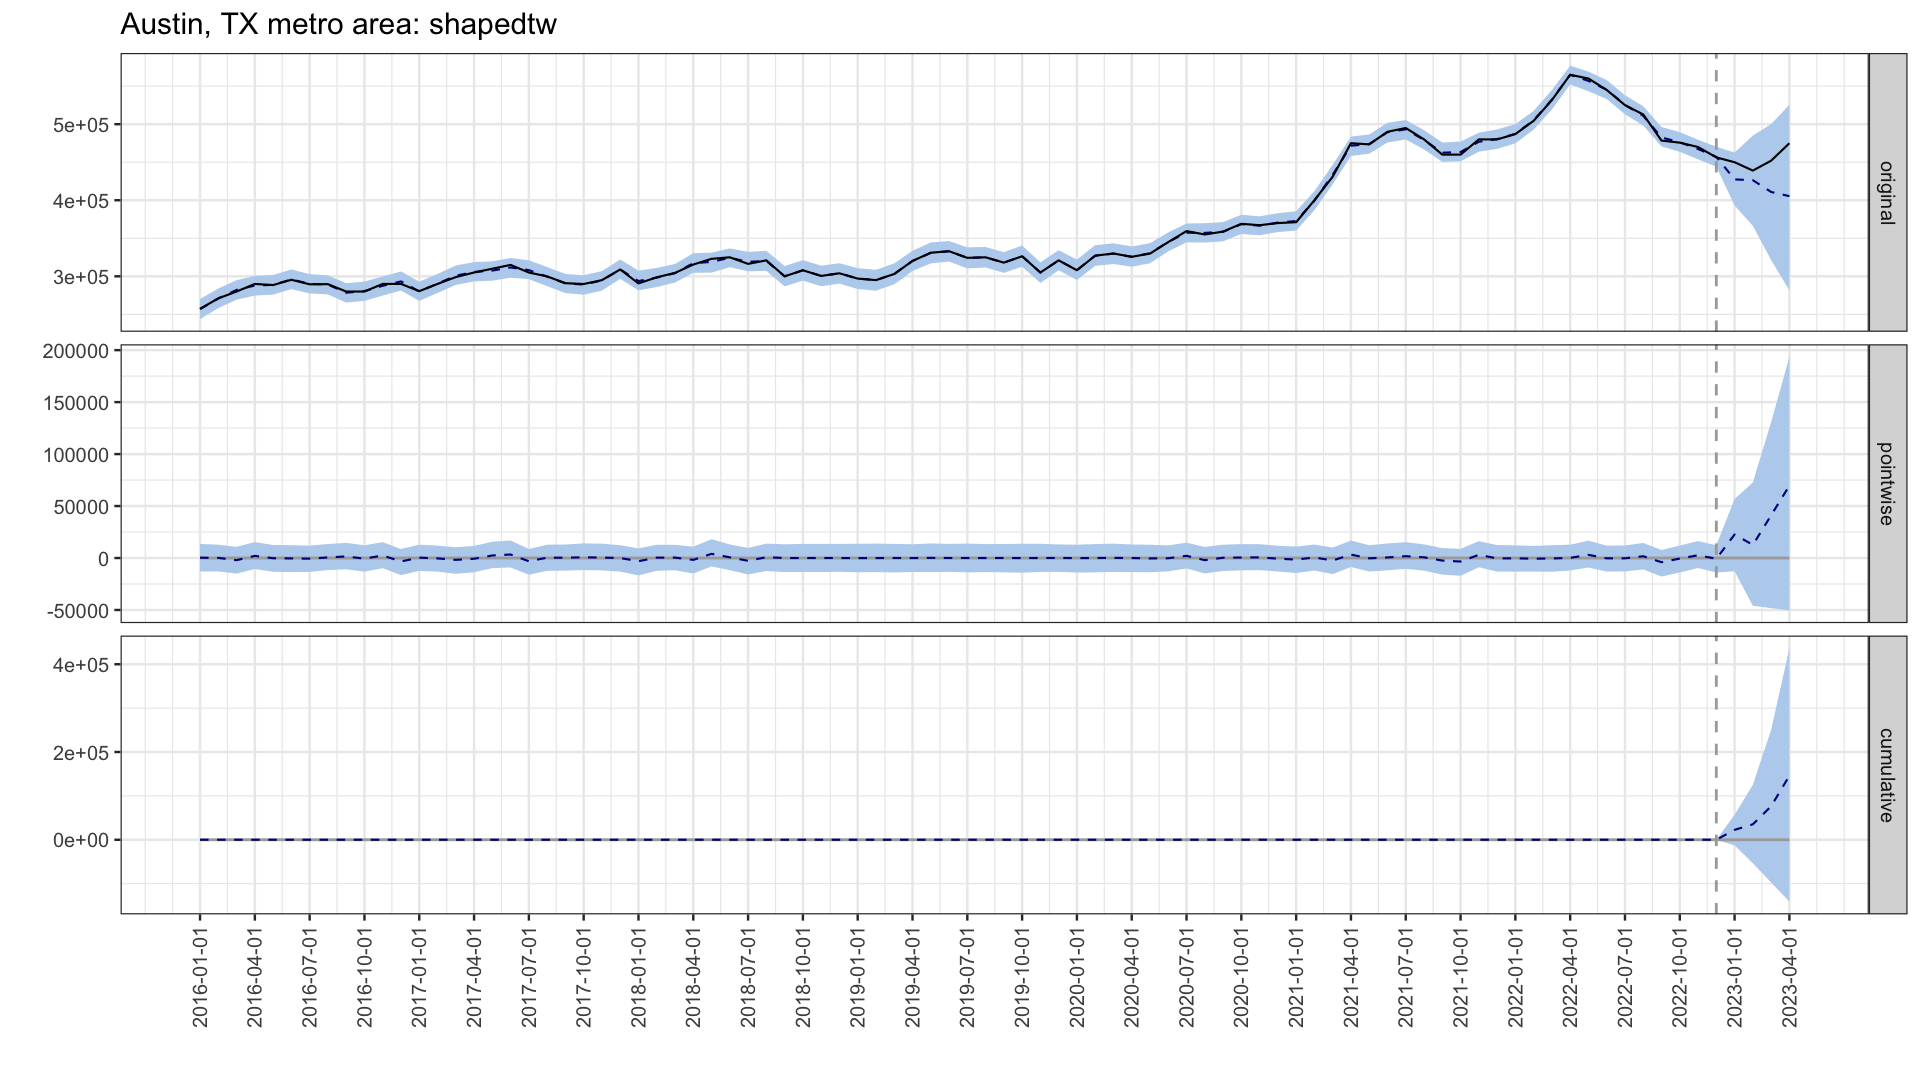

# ----- td_shapedtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        461586 (12886)     1846345 (51545)   
95% CI                   [434026, 486661]   [1736104, 1946645]
                                                              
Absolute effect (s.d.)   -7586 (12886)      -30345 (51545)    
95% CI                   [-32661, 19974]    [-130645, 79896]  
                                                              
Relative effect (s.d.)   -1.6% (2.8%)       -1.6% (2.8%)      
95% CI                   [-7.1%, 4.3%]      [-7.1%, 4.3%]     

Posterior tail-area probability p:   0.25552
Posterior prob. of a causal effect:  74%

For more details, type: summary(impact, "report")



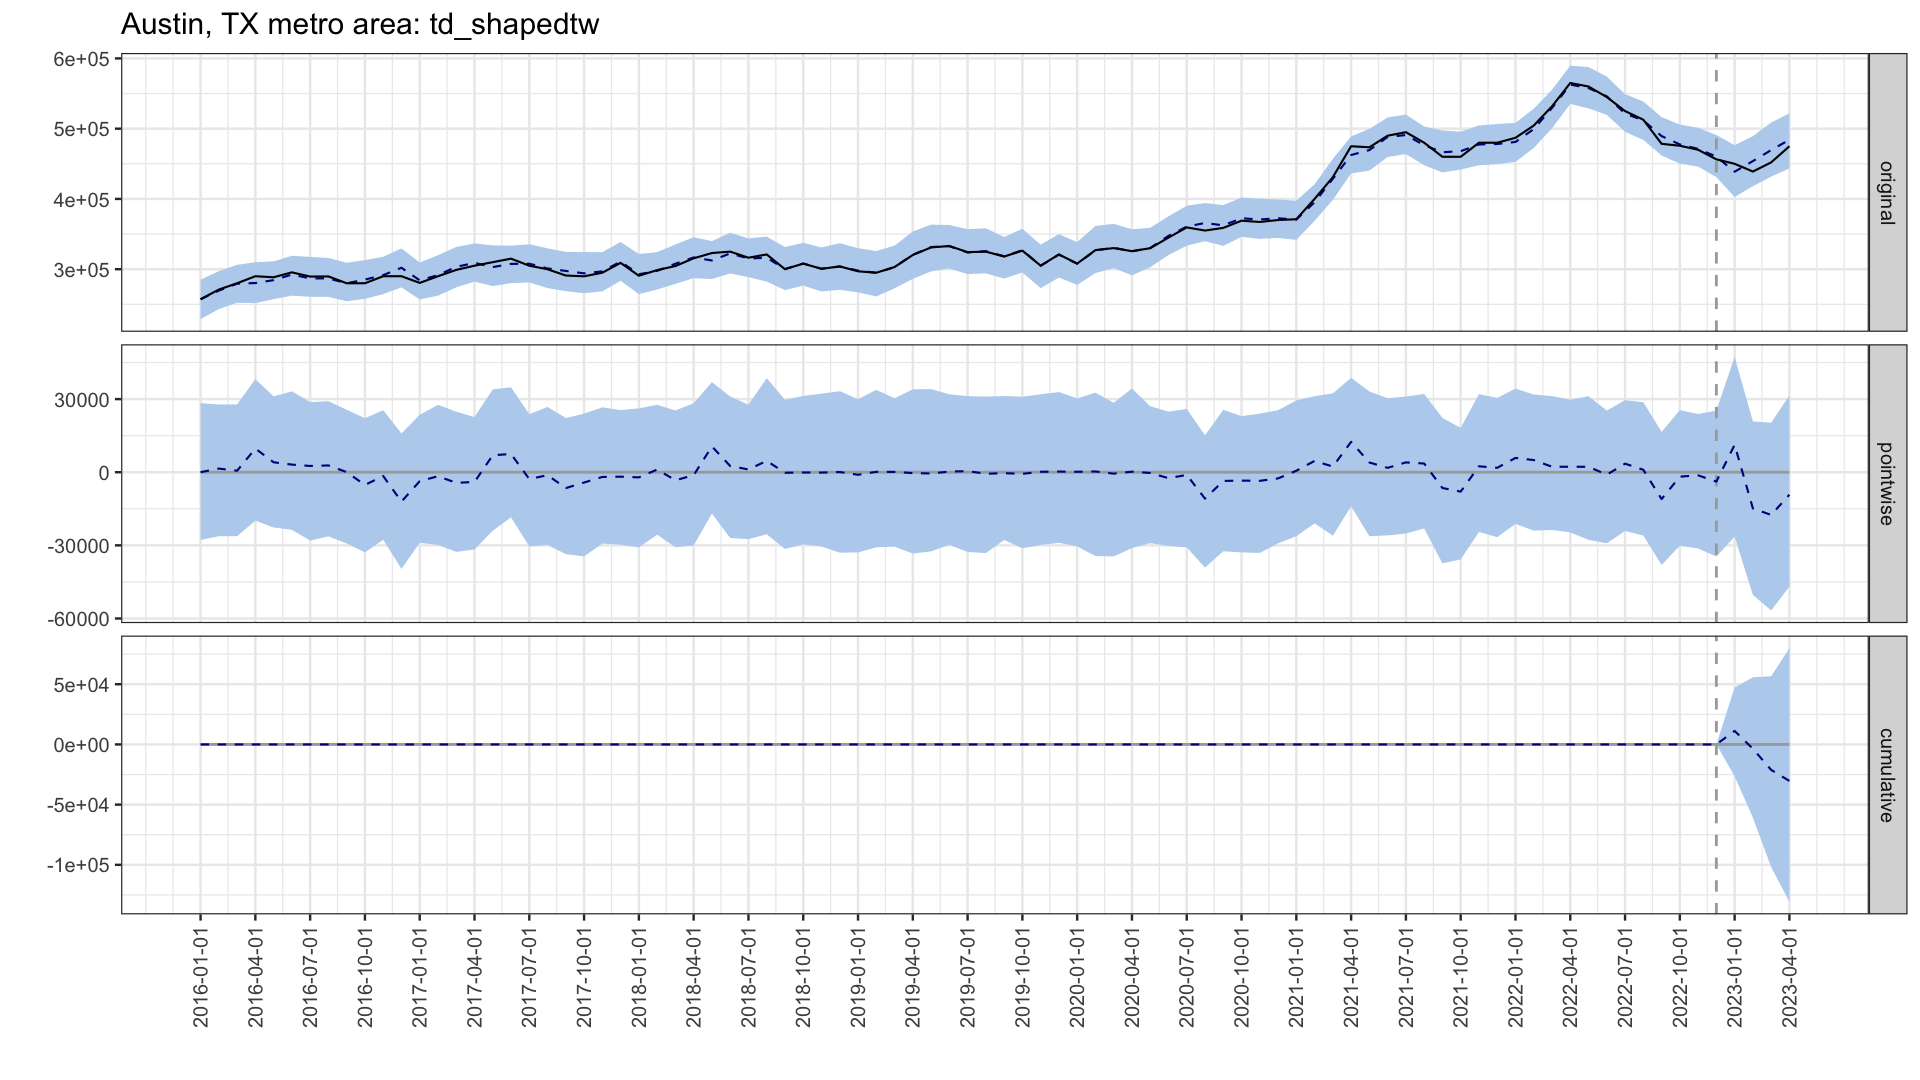

In [22]:
causal_Austin <- CausalImpactModel(metro_name = "Austin, TX metro area")

#### 5.3 Top 1 Matching

Time difference of 38.51 secs
# ----- dtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1413880 (113411)     5655520 (453643)  
95% CI                   [1187810, 1636713]   [4751238, 6546852]
                                                                
Absolute effect (s.d.)   139120 (113411)      556480 (453643)   
95% CI                   [-83713, 365190]     [-334852, 1460762]
                                                                
Relative effect (s.d.)   9.8% (8%)            9.8% (8%)         
95% CI                   [-5.9%, 26%]         [-5.9%, 26%]      

Posterior tail-area probability p:   0.10817
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



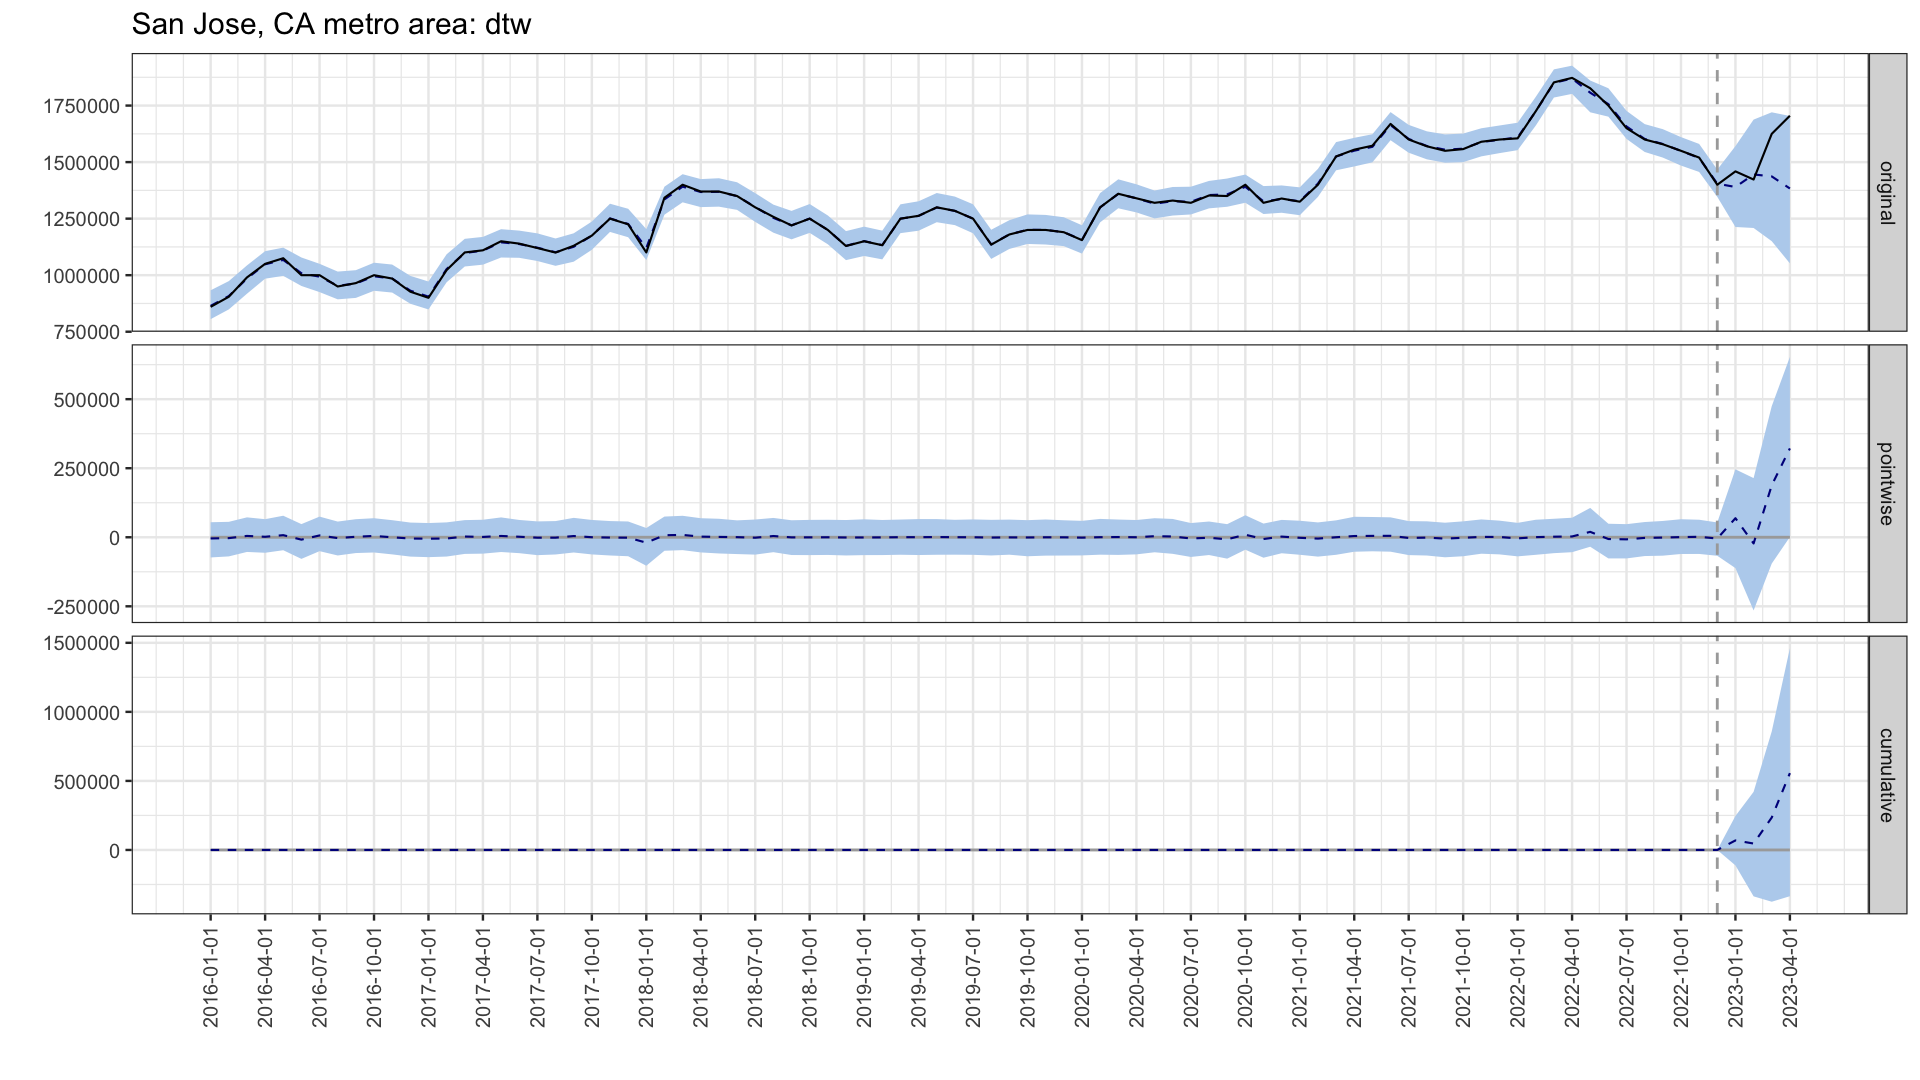

# ----- wdtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1451427 (75937)      5805709 (303749)  
95% CI                   [1299311, 1599973]   [5197244, 6399890]
                                                                
Absolute effect (s.d.)   101573 (75937)       406291 (303749)   
95% CI                   [-46973, 253689]     [-187890, 1014756]
                                                                
Relative effect (s.d.)   7% (5.2%)            7% (5.2%)         
95% CI                   [-3.2%, 17%]         [-3.2%, 17%]      

Posterior tail-area probability p:   0.08619
Posterior prob. of a causal effect:  91%

For more details, type: summary(impact, "report")



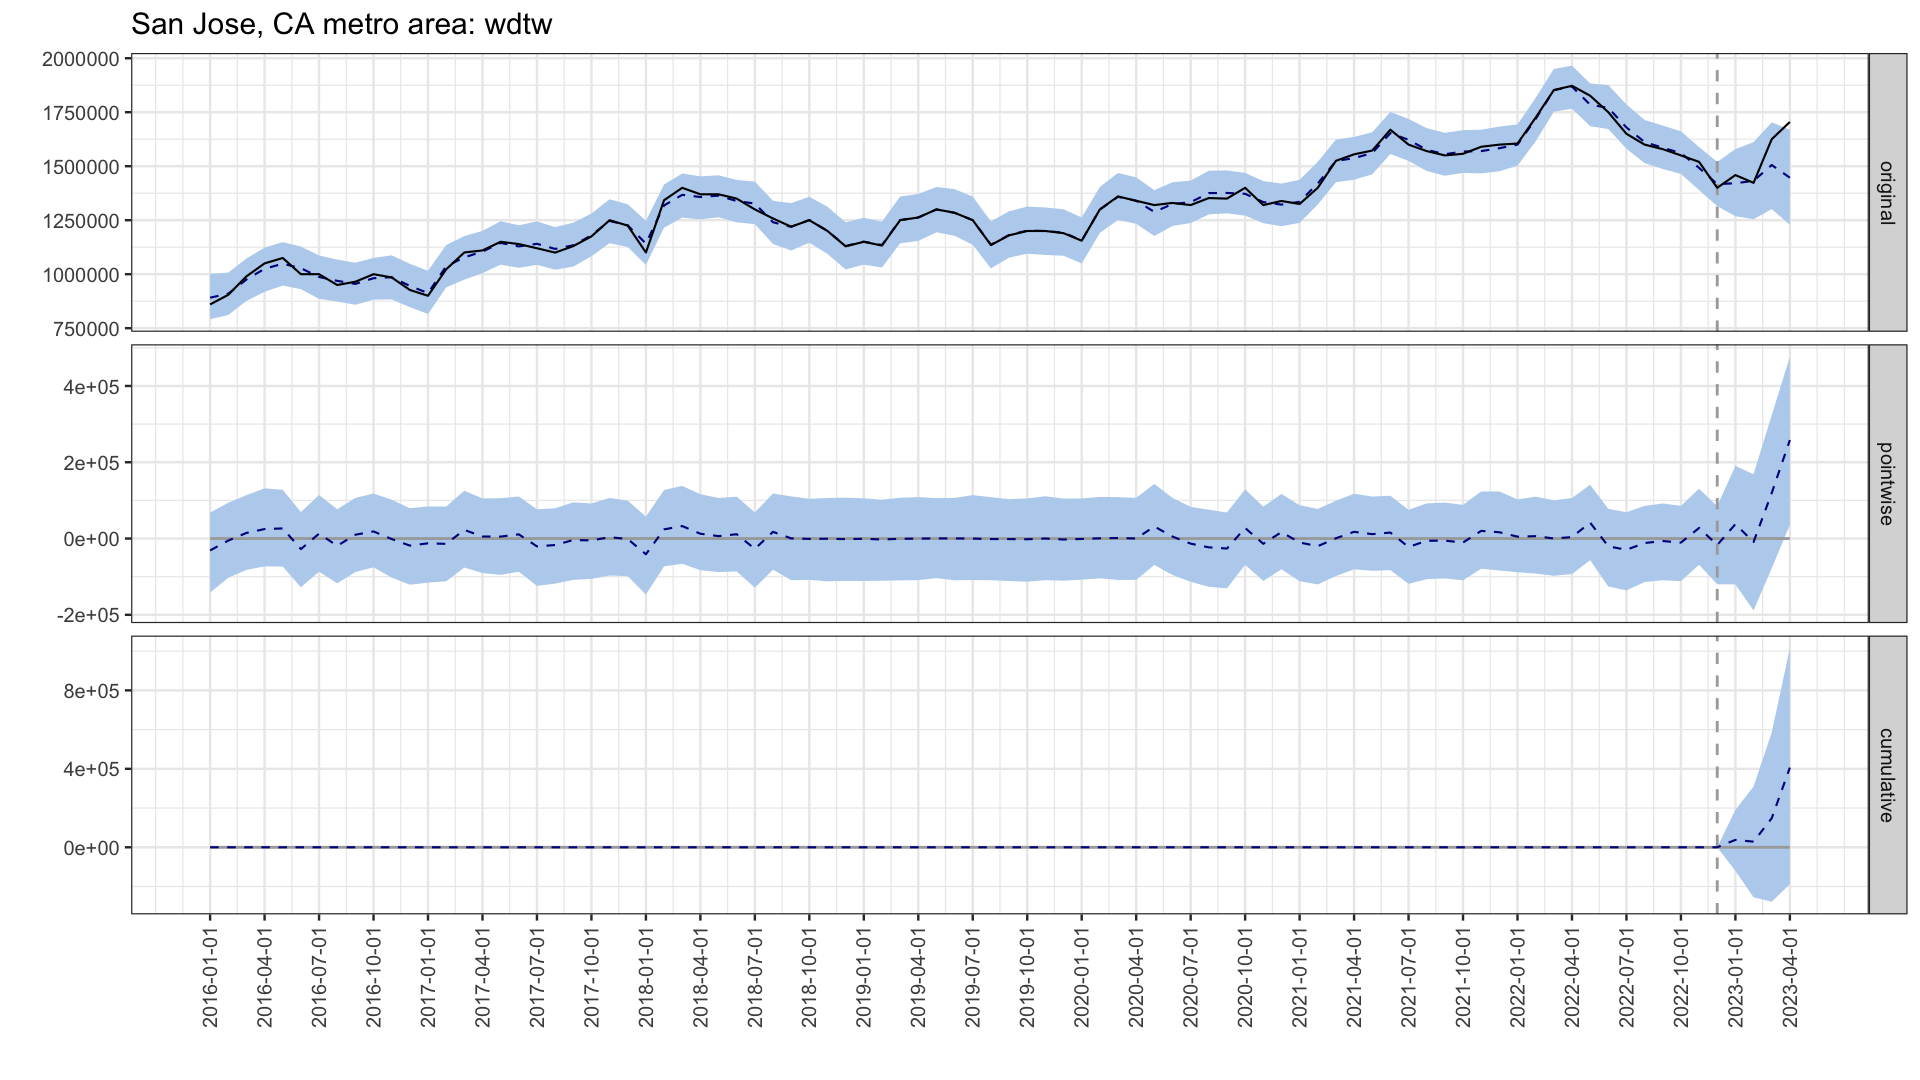

# ----- td_wdtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1453677 (77932)      5814708 (311727)  
95% CI                   [1291776, 1607338]   [5167105, 6429350]
                                                                
Absolute effect (s.d.)   99323 (77932)        397292 (311727)   
95% CI                   [-54338, 261224]     [-217350, 1044895]
                                                                
Relative effect (s.d.)   6.8% (5.4%)          6.8% (5.4%)       
95% CI                   [-3.7%, 18%]         [-3.7%, 18%]      

Posterior tail-area probability p:   0.09402
Posterior prob. of a causal effect:  91%

For more details, type: summary(impact, "report")



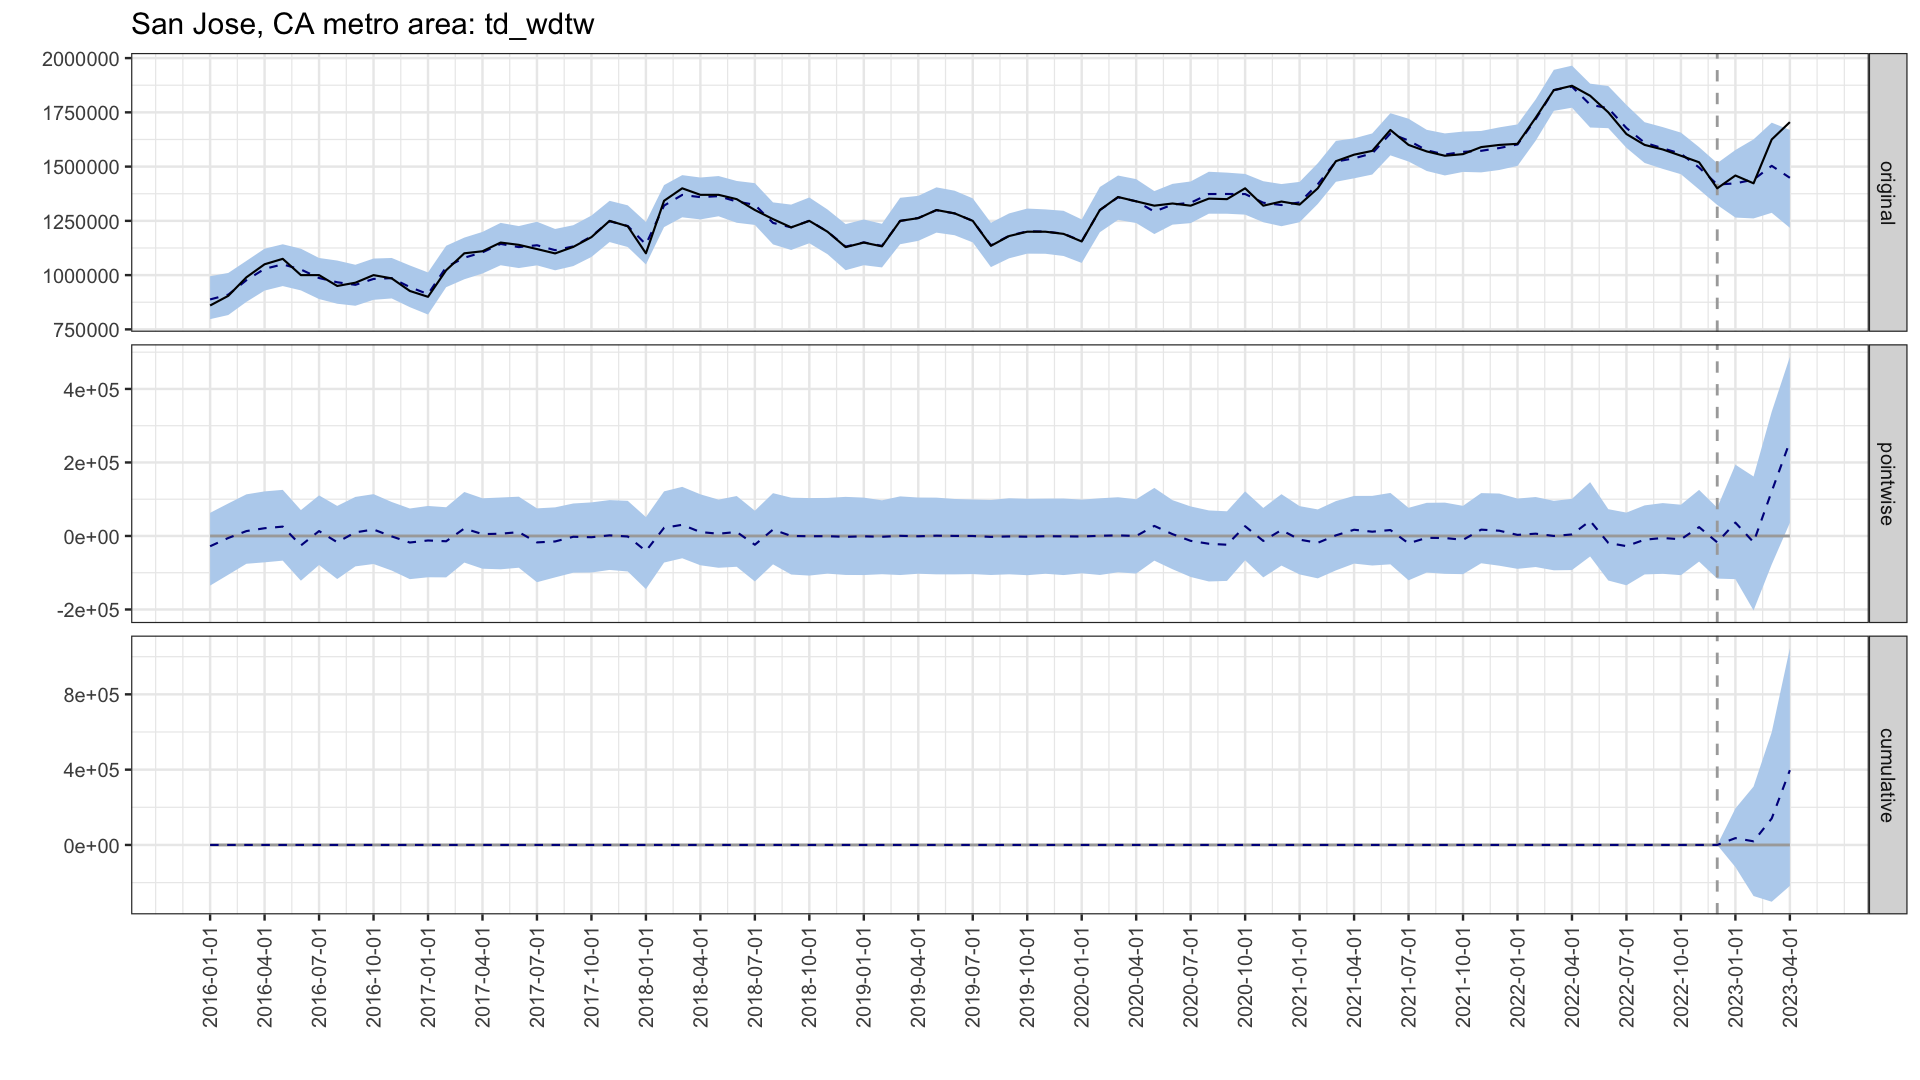

# ----- shapedtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1401933 (115134)     5607730 (460537)  
95% CI                   [1173833, 1623901]   [4695332, 6495604]
                                                                
Absolute effect (s.d.)   151067 (115134)      604270 (460537)   
95% CI                   [-70901, 379167]     [-283604, 1516668]
                                                                
Relative effect (s.d.)   11% (8.2%)           11% (8.2%)        
95% CI                   [-5.1%, 27%]         [-5.1%, 27%]      

Posterior tail-area probability p:   0.0898
Posterior prob. of a causal effect:  91%

For more details, type: summary(impact, "report")



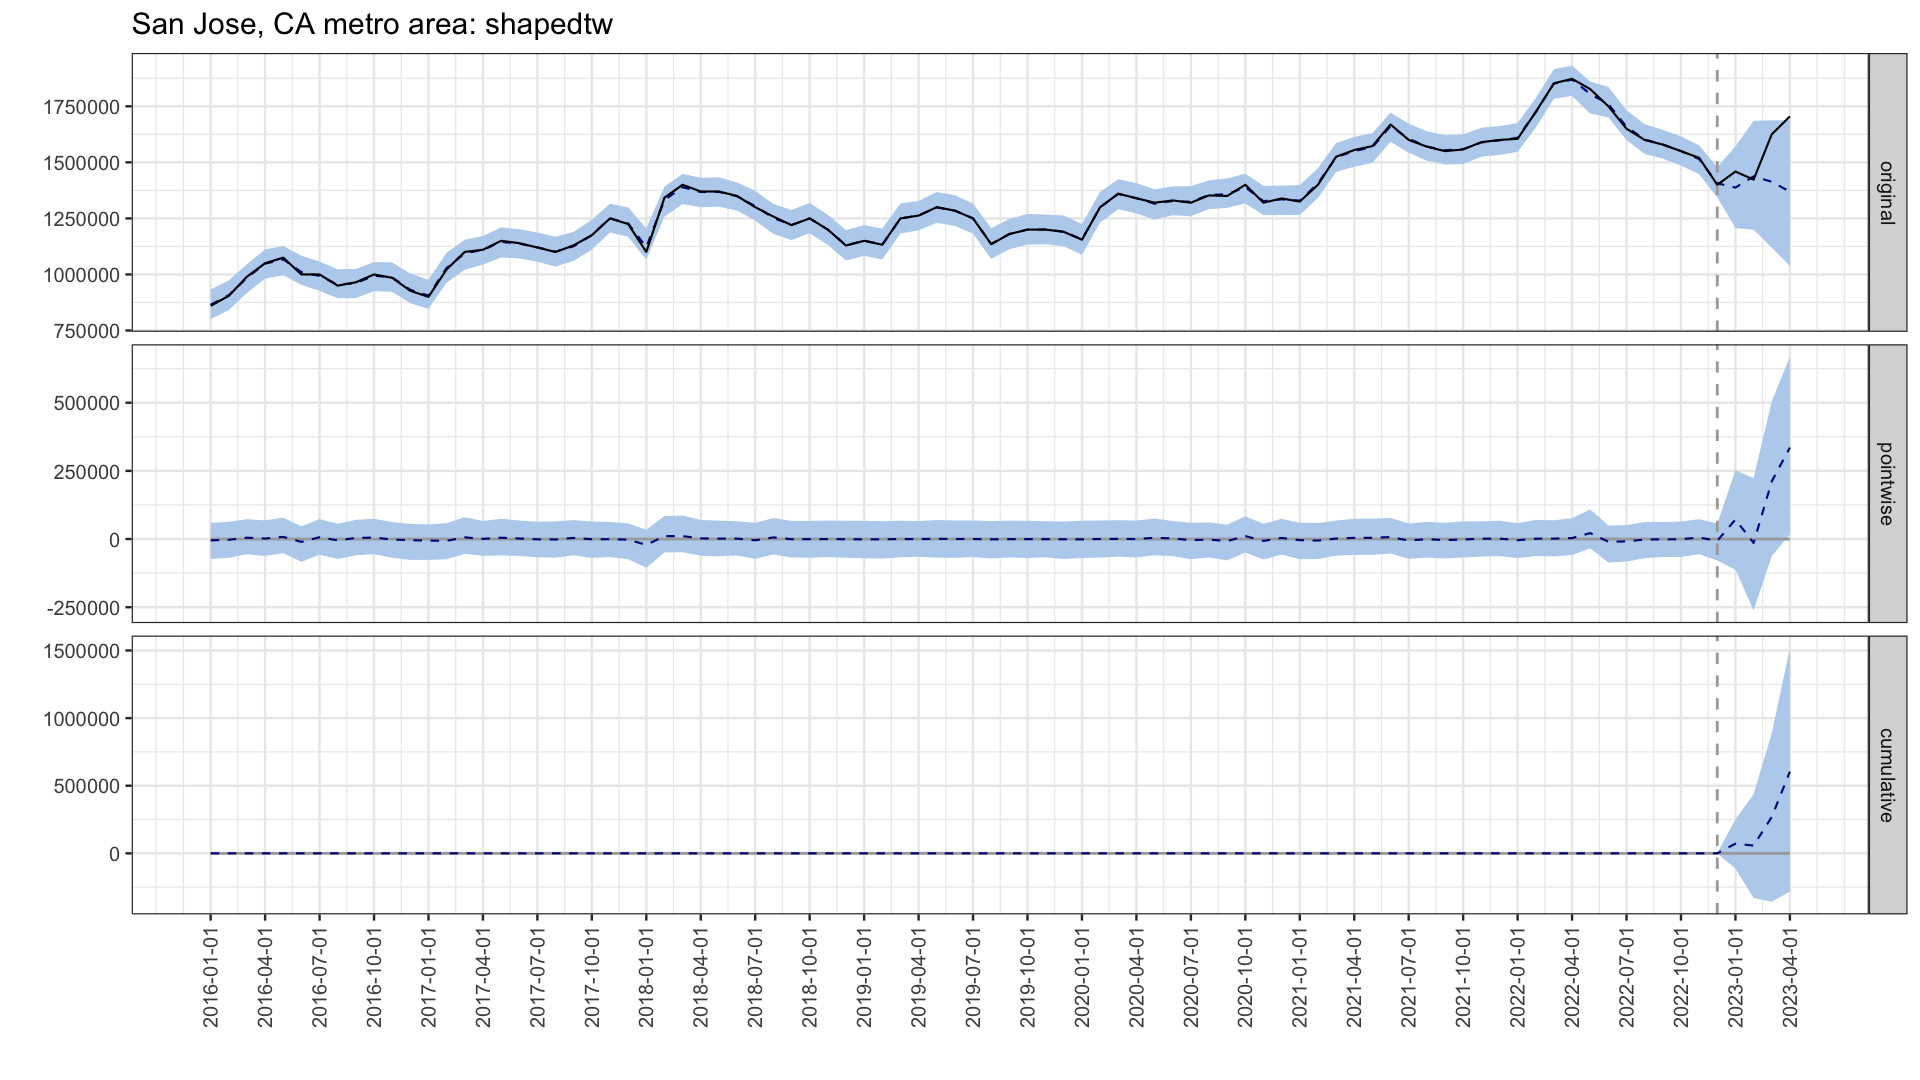

# ----- td_shapedtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1462542 (70969)      5850169 (283874)  
95% CI                   [1314935, 1599058]   [5259741, 6396232]
                                                                
Absolute effect (s.d.)   90458 (70969)        361831 (283874)   
95% CI                   [-46058, 238065]     [-184232, 952259] 
                                                                
Relative effect (s.d.)   6.2% (4.9%)          6.2% (4.9%)       
95% CI                   [-3.1%, 16%]         [-3.1%, 16%]      

Posterior tail-area probability p:   0.09754
Posterior prob. of a causal effect:  90%

For more details, type: summary(impact, "report")



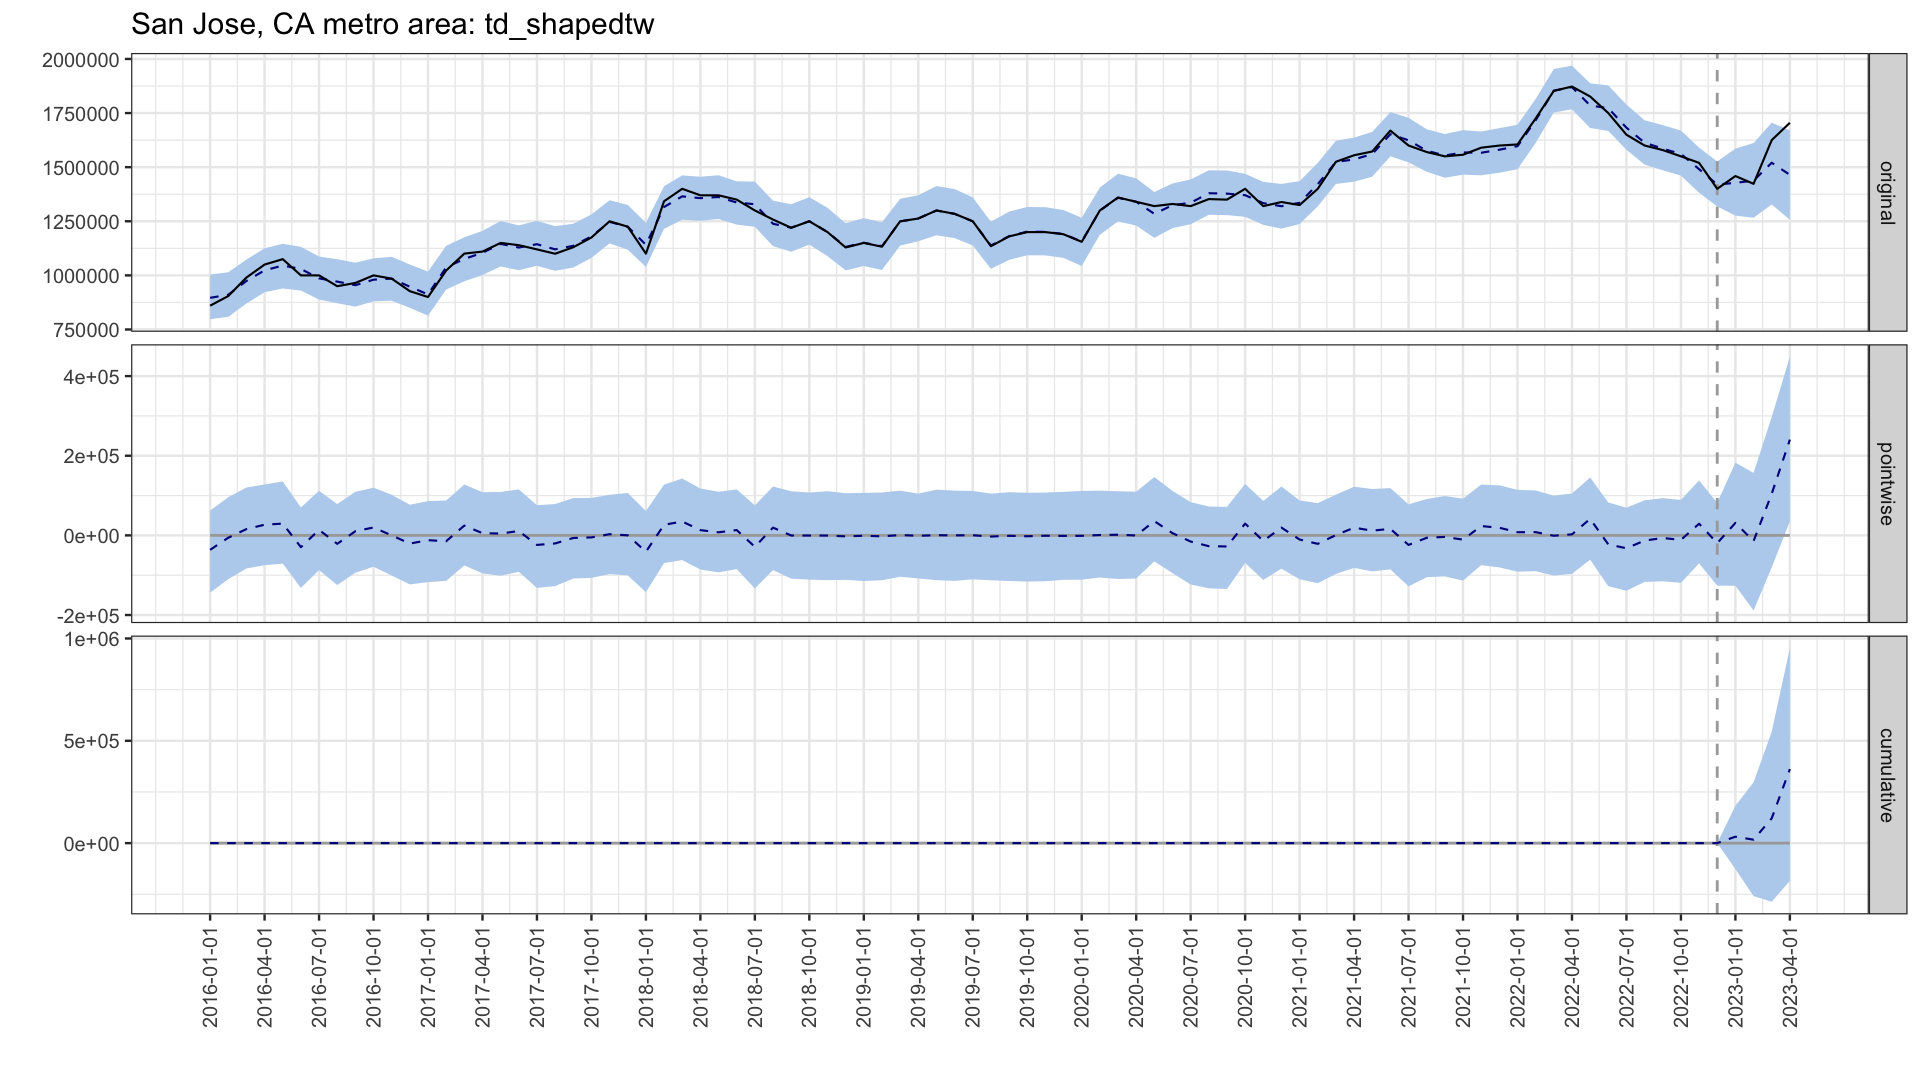

In [23]:
causal_SanJose_rank1st <- CausalImpactModel(metro_name = "San Jose, CA metro area", alpha = 0.05, num_query = 1)

### 6. Predict with BSTS

In [66]:
length(unique(dt_nonNA$region))

[1] 856

In [49]:
BSTSModel <- function(metro_name, alpha = 0.05, num_query = 10){
  
  # Get the distances and ranking of control metros
  output <- calMetroDist(metro_name = metro_name)
  metro_t_dist <- as.data.frame(output$metro_t_dist)
  metro_t_dist_results <- output$metro_t_dist_results
  
  # Output initialization
  pred_results_list_0 <- pred_results_list_1 <- pred_results_list_2 <- pred_results_list_3 <- pred_results_list_full <- list()
  mape_list_0 <- mape_list_1 <- mape_list_2 <- mape_list_3 <- mape_list_full <- list()

  # Loop through varying metrics
  for (i in 1:length(metrics_rank)){
    
    # Get top 10 control and the treatment metro
    metric_index <- which(colnames(metro_t_dist)== metrics_rank[i])
    metro_t <- metro_t_dist[order(metro_t_dist[, metric_index]), ]$region[1]
    metro_c <- metro_t_dist[order(metro_t_dist[, metric_index]), ]$region[2:(num_query+1)]
    
    # Get the target variable: median sale price
    dt_metro_t <- dt_sel[(region == metro_t) & (period_begin <= end_date)]
    dt_metro_c_all <- dt_sel[(region %in% metro_c) & (period_begin <= end_date)]
    dt_metro_c <- dt_metro_c_all[, .(median_sale_price_c = mean(median_sale_price)), by = period_begin]
    
    # Final data used in BSTS model
    dt_final <- as.data.frame(merge(dt_metro_t[, c("period_begin", "median_sale_price")], 
                                    dt_metro_c, 
                                    by = "period_begin"))
    dt_final <- zoo(dt_final[,2:3], month_list)
    
    # Define training and holdout data
    cut_dt <- 12 * 6 + 6
    training <- dt_final[1:cut_dt,]
    holdout_1 <- dt_final[(cut_dt+1):(cut_dt+3), ]
    holdout_2 <- dt_final[(cut_dt+4):(cut_dt+6), ]
    holdout_3 <- dt_final[(cut_dt+7):length(month_list), ]
    
    # Use BSTS package to specify custom model by adding seasonality and local linear trend
    ss <- list()
    ss <- AddSeasonal(ss, y = training$median_sale_price, nseasons = 12) # Add seasonality
    ss <- AddLocalLinearTrend(ss, y = training$median_sale_price) # Add linear trend (upward)
    bsts_model_0 <- bsts(training$median_sale_price, state.specification = ss, niter = 2000, ping = 0)
    bsts_model_1 <- bsts(median_sale_price ~., state.specification = ss, data = training, niter = 2000, ping = 0)
    bsts_model_2 <- bsts(median_sale_price ~., state.specification = ss, data = rbind(training, holdout_1), niter = 2000, ping = 0)
    bsts_model_3 <- bsts(median_sale_price ~., state.specification = ss, data = rbind(training, holdout_1, holdout_2), niter = 2000, ping = 0)
    bsts_model_full <- bsts(median_sale_price ~., state.specification = ss, data = training, niter = 2000, ping = 0)

    # Plot prediction results
    pred_0 <- predict(bsts_model_0, horizon = nrow(rbind(holdout_1, holdout_2, holdout_3)), burn = 400)
    pred_1 <- predict(bsts_model_1, newdata = holdout_1, burn = 400) # 7-9
    pred_2 <- predict(bsts_model_2, newdata = holdout_2, burn = 400) # 10-12
    pred_3 <- predict(bsts_model_3, newdata = holdout_3, burn = 400) # 1-4
    pred_full <- predict(bsts_model_full, newdata = rbind(holdout_1, holdout_2, holdout_3), burn = 400) # 7-4
    #options(repr.plot.width = 12, repr.plot.height = 5)
    #plot(pred)
    cat(paste("# -----", metrics[i], "-----\n"))
    
    # Evaludate model performance: MAPE
    y_actual_1 <- as.numeric(holdout_1$median_sale_price) 
    y_actual_2 <- as.numeric(holdout_2$median_sale_price) 
    y_actual_3 <- as.numeric(holdout_3$median_sale_price) 
    y_actual_full <- as.numeric(rbind(holdout_1, holdout_2, holdout_3)$median_sale_price)
    mape_0 <- round(mean(abs(pred_0$mean - y_actual_full)/y_actual_full) * 100, 2)
    mape_1 <- round(mean(abs(pred_1$mean - y_actual_1)/y_actual_1) * 100, 2)
    mape_2 <- round(mean(abs(pred_2$mean - y_actual_2)/y_actual_2) * 100, 2)
    mape_3 <- round(mean(abs(pred_3$mean - y_actual_3)/y_actual_3) * 100, 2)
    mape_full <- round(mean(abs(pred_full$mean - y_actual_full)/y_actual_full) * 100, 2)

    # Save the output
    pred_results_list_0[[i]] <- pred_0
    pred_results_list_1[[i]] <- pred_1
    pred_results_list_2[[i]] <- pred_2
    pred_results_list_3[[i]] <- pred_3
    pred_results_list_full[[i]] <- pred_full
    mape_list_0[[i]] <- mape_0
    mape_list_1[[i]] <- mape_1
    mape_list_2[[i]] <- mape_2
    mape_list_3[[i]] <- mape_3
    mape_list_full[[i]] <- mape_full
  }
  
  return(list(
    "metro_t_dist" = metro_t_dist,
    "metro_t_dist_results" = metro_t_dist_results,
    "model_prediction_results_0" = pred_results_list_0,
    "model_prediction_results_1" = pred_results_list_1,
    "model_prediction_results_2" = pred_results_list_2,
    "model_prediction_results_3" = pred_results_list_3,
    "model_prediction_results_full" = pred_results_list_full,
    "model_mape_0" = mape_list_0,
    "model_mape_1" = mape_list_1,
    "model_mape_2" = mape_list_2,
    "model_mape_3" = mape_list_3,
    "model_mape_full" = mape_list_full
    ))
}

In [51]:
mapeCalc <- function(bsts_model){
  mape <- as.data.frame(rbind(
    metrics, 
    bsts_model$model_mape_1,
    bsts_model$model_mape_2,
    bsts_model$model_mape_3,
    bsts_model$model_mape_full,
    bsts_model$model_mape_0
  ))
  rownames(mape) <- c("matching_algorithm", "mape (7-9)", "mape(10-12)", "mape (1-4)", "mape (7-4)", "mape org (7-4)")
  return(mape)
}

#### 6.1 BSTS Model Implementation

Five metro areas are experimented: 
- Detroit, MI
- Seattle, WA
- Austin, TX
- San Jose, CA
- New York, NY
- Chicago, IL

In [50]:
bsts_detroit <- BSTSModel("Detroit, MI metro area", num_query = 5)

Time difference of 1.01 mins
# ----- dtw -----
# ----- wdtw -----
# ----- td_wdtw -----
# ----- shapedtw -----
# ----- td_shapedtw -----


In [62]:
bsts_kansas <- BSTSModel("Kansas City, MO metro area", num_query = 5)

Time difference of 1.11 mins
# ----- dtw -----
# ----- wdtw -----
# ----- td_wdtw -----
# ----- shapedtw -----
# ----- td_shapedtw -----


In [55]:
bsts_austin <- BSTSModel("Pittsburgh, PA metro area", num_query = 5)

Time difference of 54.05 secs
# ----- dtw -----
# ----- wdtw -----
# ----- td_wdtw -----
# ----- shapedtw -----
# ----- td_shapedtw -----


In [57]:
bsts_newyork <- BSTSModel("New York, NY metro area", num_query = 5)

Time difference of 1.19 mins
# ----- dtw -----
# ----- wdtw -----
# ----- td_wdtw -----
# ----- shapedtw -----
# ----- td_shapedtw -----


In [59]:
bsts_chicago <- BSTSModel("Chicago, IL metro area", num_query = 5)

Time difference of 56.62 secs
# ----- dtw -----
# ----- wdtw -----
# ----- td_wdtw -----
# ----- shapedtw -----
# ----- td_shapedtw -----


#### 6.2 Evaluate Model with MAPE

In [163]:
mapeCalc(bsts_detroit)

V1   V2    V3      V4       V5         
matching_algorithm dtw  wdtw  td_wdtw shapedtw td_shapedtw
mape (7-9)         3.26 6.66  2.61    2.85     5.6        
mape(10-12)        1.7  1.22  2.8     3.2      3.44       
mape (1-4)         2.65 4.43  3       2.67     4.9        
mape (7-4)         2.57 18.21 4.85    8.12     4.54

In [63]:
mapeCalc(bsts_kansas)

V1   V2   V3      V4       V5         
matching_algorithm dtw  wdtw td_wdtw shapedtw td_shapedtw
mape (7-9)         3.04 3.62 3.5     2.61     3.53       
mape(10-12)        2.48 1.94 2.67    1.23     1.84       
mape (1-4)         3.49 3.99 3.48    3.7      3.29       
mape (7-4)         7.68 8.85 7.64    5.67     4.85       
mape org (7-4)     9.99 9.14 9.22    9.58     9.65

In [56]:
mapeCalc(bsts_austin)

V1    V2    V3      V4       V5         
matching_algorithm dtw   wdtw  td_wdtw shapedtw td_shapedtw
mape (7-9)         7.55  7.34  7.4     7.25     7.44       
mape(10-12)        2.3   1.96  2.42    3.13     1.89       
mape (1-4)         1.67  1.96  1.63    1.68     1.77       
mape (7-4)         17.59 15.77 17.74   15.48    17.05      
mape org (7-4)     14.03 19.23 18.57   19.52    18.86

In [58]:
mapeCalc(bsts_newyork)

V1   V2   V3      V4       V5         
matching_algorithm dtw  wdtw td_wdtw shapedtw td_shapedtw
mape (7-9)         2.01 1.57 2.36    1.89     2.41       
mape(10-12)        3.18 2    3.37    2.95     1.62       
mape (1-4)         1.89 1.84 1.78    1.98     1.59       
mape (7-4)         5.41 5.93 5.99    5.2      5.03       
mape org (7-4)     6.15 6.44 6.07    6.1      6.27

In [60]:
mapeCalc(bsts_chicago)

V1    V2    V3      V4       V5         
matching_algorithm dtw   wdtw  td_wdtw shapedtw td_shapedtw
mape (7-9)         5.9   6.84  6.52    5.1      6.66       
mape(10-12)        0.77  1.16  0.78    1.45     1.07       
mape (1-4)         2.32  2.33  2.72    2.61     2.5        
mape (7-4)         8.39  7.91  11.17   9.75     10.25      
mape org (7-4)     10.42 10.57 10.54   10.18    11.05

### Prediction Exercise

BSTS:

1. Use **DTW, WDTW, TD-WDTW, ShapeDTW, and TD-ShapeDTW** to find the top 10 or 20 matching results with data from 2016-01-01 to 2022-12-01 (6-year montly data), respectively

2. **Train 5 BSTS models** using the top 10 or 20 matching results from different methods

3. **Predict the price trend** in the first four months in 2023 based on the trained BSTS models

ML model (XGBoost, LSTM, Gated RNN):

+ stock market data (prediction purpose: US ~ UK, Singapore, Hongkong, Japan, France/Germany)

+ semi-conduct industry

References:

+ https://otexts.com/fpp3/advanced.htmlhttps://otexts.com/fpp3/advanced.html